In [149]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import DistanceMetric
import scipy.cluster.hierarchy as sch
from paretochart import pareto
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import euclidean_distances
import importlib
import ML
importlib.reload(ML)


<module 'ML' from 'c:\\Users\\apmle\\OneDrive\\Documents\\Bootcamp\\Leandro_AnaPaula_NaoSupervisionado\\ML.py'>

In [32]:
data_dict = pd.read_csv('data-dictionary.csv')
data = pd.read_csv('Country-data.csv')

In [33]:
data_dict

Column Name                                        Description
0     country                                Name of the country
1  child_mort  Death of children under 5 years of age per 100...
2     exports  Exports of goods and services per capita. Give...
3      health  Total health spending per capita. Given as %ag...
4     imports  Imports of goods and services per capita. Give...
5      Income                              Net income per person
6   Inflation  The measurement of the annual growth rate of t...
7  life_expec  The average number of years a new born child w...
8   total_fer  The number of children that would be born to e...
9        gdpp  The GDP per capita. Calculated as the Total GD...

In [34]:
data

country  child_mort  exports  health  imports  income  \
0            Afghanistan        90.2     10.0    7.58     44.9    1610   
1                Albania        16.6     28.0    6.55     48.6    9930   
2                Algeria        27.3     38.4    4.17     31.4   12900   
3                 Angola       119.0     62.3    2.85     42.9    5900   
4    Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   
..                   ...         ...      ...     ...      ...     ...   
162              Vanuatu        29.2     46.6    5.25     52.7    2950   
163            Venezuela        17.1     28.5    4.91     17.6   16500   
164              Vietnam        23.3     72.0    6.84     80.2    4490   
165                Yemen        56.3     30.0    5.18     34.4    4480   
166               Zambia        83.1     37.0    5.89     30.9    3280   

     inflation  life_expec  total_fer   gdpp  
0         9.44        56.2       5.82    553  
1         4.49        76.3       1.65   4090  
2        16.10        76.5       2.89   4460  
3        22.40        60.1       6.16   3530  
4         1.44        76.8       2.13  12200  
..         ...         ...        ...    ...  
162       2.62        63.0       3.50   2970  
163      45.90        75.4       2.47  13500  
164      12.10        73.1       1.95   1310  
165      23.60        67.5       4.67   1310  
166      14.00        52.0       5.40   1460  

[167 rows x 10 columns]

### Number of Countries

In [35]:
countries = data['country'].unique

In [36]:
countries

<bound method Series.unique of 0              Afghanistan
1                  Albania
2                  Algeria
3                   Angola
4      Antigua and Barbuda
              ...         
162                Vanuatu
163              Venezuela
164                Vietnam
165                  Yemen
166                 Zambia
Name: country, Length: 167, dtype: object>

In [37]:
countries=data['country']

In [38]:
countries.isnull().sum()

0

In [39]:
num_country = countries.shape[0]

In [40]:
num_country

167

#### Data PreProcessing

In [41]:
data.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [42]:
data.describe()

child_mort     exports      health     imports         income  \
count  167.000000  167.000000  167.000000  167.000000     167.000000   
mean    38.270060   41.108976    6.815689   46.890215   17144.688623   
std     40.328931   27.412010    2.746837   24.209589   19278.067698   
min      2.600000    0.109000    1.810000    0.065900     609.000000   
25%      8.250000   23.800000    4.920000   30.200000    3355.000000   
50%     19.300000   35.000000    6.320000   43.300000    9960.000000   
75%     62.100000   51.350000    8.600000   58.750000   22800.000000   
max    208.000000  200.000000   17.900000  174.000000  125000.000000   

        inflation  life_expec   total_fer           gdpp  
count  167.000000  167.000000  167.000000     167.000000  
mean     7.781832   70.555689    2.947964   12964.155689  
std     10.570704    8.893172    1.513848   18328.704809  
min     -4.210000   32.100000    1.150000     231.000000  
25%      1.810000   65.300000    1.795000    1330.000000  
50%      5.390000   73.100000    2.410000    4660.000000  
75%     10.750000   76.800000    3.880000   14050.000000  
max    104.000000   82.800000    7.490000  105000.000000

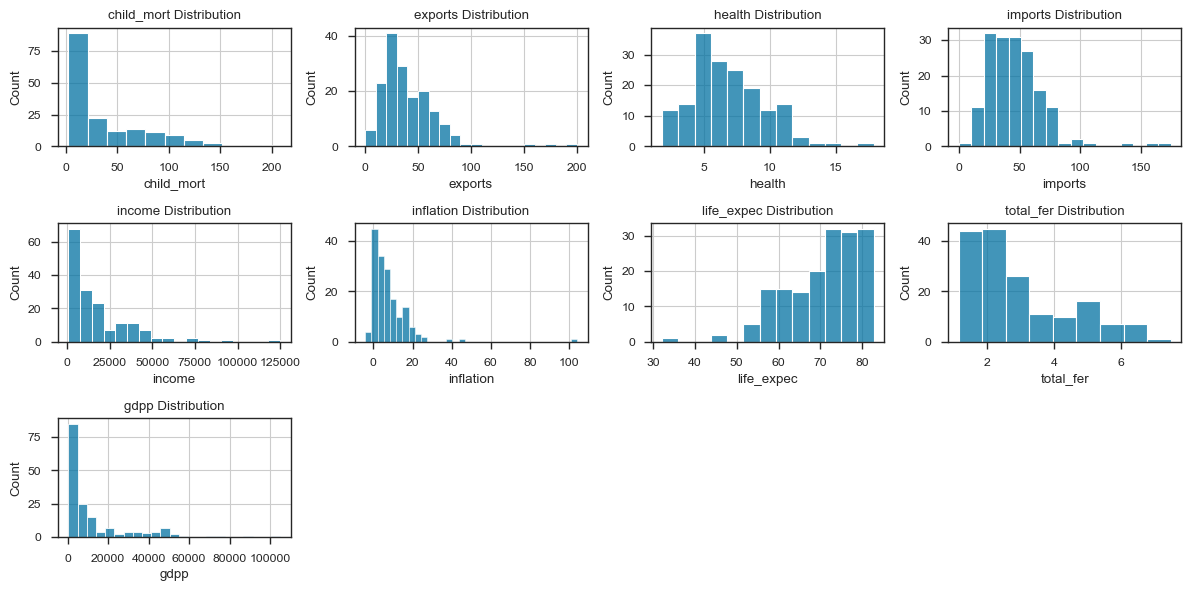

In [45]:
ML.plot_distribution_base(data.drop(columns='country'))

C:\Users\apmle\AppData\Local\Temp\ipykernel_23948\1000910638.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = data.corr()


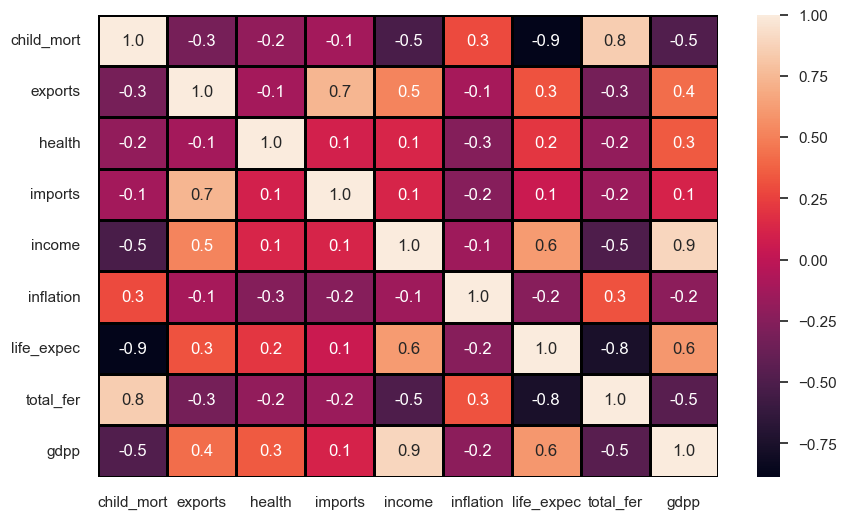

In [46]:
correlation = data.corr()
correlation
sns.set(rc = {'figure.figsize':(10,6)})
plot = sns.heatmap(correlation, annot = True, fmt=".1f", linewidths=1, linecolor='black')
plot

In [49]:
def remove_outliers(data, threshold=3):
    """
    Remove outliers from the dataset using Z-score method and reset the index.

    Parameters:
        data (numpy array or pandas DataFrame): The input dataset.
        threshold (float, optional): The Z-score threshold for outlier detection.
                                     Data points with Z-score greater than this value will be removed.
                                     Default is 3.

    Returns:
        numpy array or pandas DataFrame: Dataset with outliers removed and index reset.
    """
    # Calculate the mean and standard deviation for each column
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)

    # Calculate Z-scores for each data point in the dataset
    z_scores = np.abs((data - mean) / std)

    # Identify outliers based on the threshold
    outliers = z_scores > threshold

    # Remove rows containing any outlier in at least one column
    cleaned_data = data[~np.any(outliers, axis=1)]

    # Reset index if the input data is a pandas DataFrame
    if isinstance(data, pd.DataFrame):
        cleaned_data = cleaned_data.reset_index(drop=True)

    return cleaned_data

In [56]:
new_data = remove_outliers(data, threshold=2)

C:\Users\apmle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\apmle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3571: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return std(axis=axis, dtype=dtype, out=out, ddof

In [57]:
new_data

country  child_mort  exports  health  imports  income  \
0            Afghanistan        90.2     10.0    7.58     44.9    1610   
1                Albania        16.6     28.0    6.55     48.6    9930   
2                Algeria        27.3     38.4    4.17     31.4   12900   
3    Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   
4              Argentina        14.5     18.9    8.10     16.0   18700   
..                   ...         ...      ...     ...      ...     ...   
129              Uruguay        10.6     26.3    8.35     25.4   17100   
130           Uzbekistan        36.3     31.7    5.81     28.5    4240   
131              Vanuatu        29.2     46.6    5.25     52.7    2950   
132              Vietnam        23.3     72.0    6.84     80.2    4490   
133                Yemen        56.3     30.0    5.18     34.4    4480   

     inflation  life_expec  total_fer   gdpp  
0         9.44        56.2       5.82    553  
1         4.49        76.3       1.65   4090  
2        16.10        76.5       2.89   4460  
3         1.44        76.8       2.13  12200  
4        20.90        75.8       2.37  10300  
..         ...         ...        ...    ...  
129       4.91        76.4       2.08  11900  
130      16.50        68.8       2.34   1380  
131       2.62        63.0       3.50   2970  
132      12.10        73.1       1.95   1310  
133      23.60        67.5       4.67   1310  

[134 rows x 10 columns]

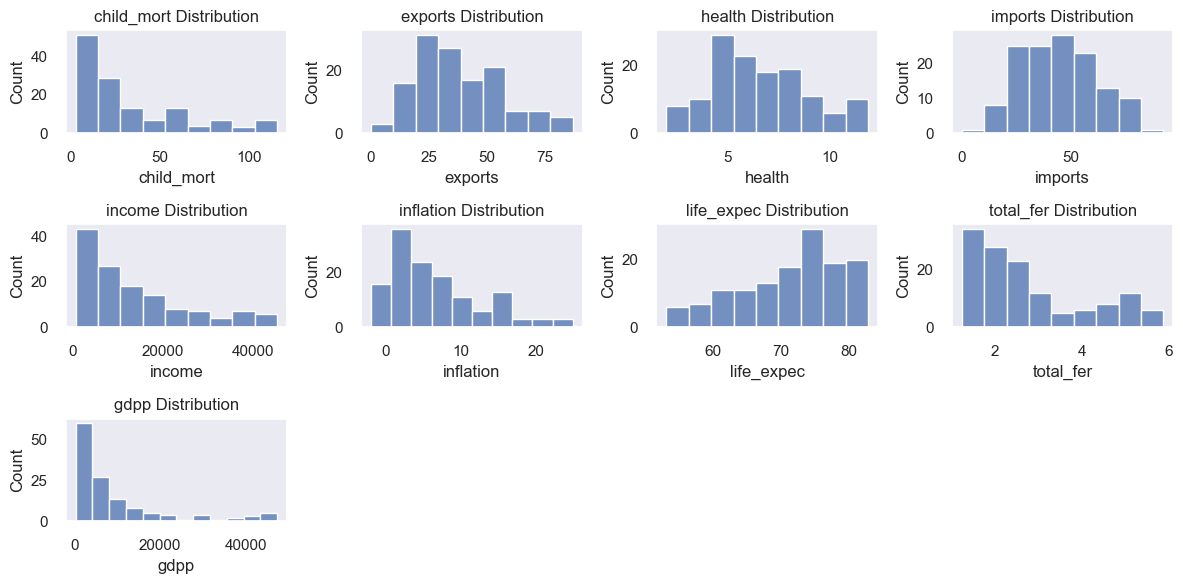

In [58]:
ML.plot_distribution_base(new_data.drop(columns='country'))

In [59]:
def log_transform(data):
    """
    Transform the dataset to log scale using natural logarithm (log base e).

    Parameters:
        data (numpy array or pandas DataFrame): The input dataset.

    Returns:
        numpy array or pandas DataFrame: Dataset with log transformation applied.
    """
    # Use numpy's log function to calculate the natural logarithm
    log_data = np.log(data)

    # If the input data is a pandas DataFrame, create a new DataFrame with the log-transformed values
    if isinstance(data, pd.DataFrame):
        log_data = pd.DataFrame(log_data, columns=data.columns, index=data.index)

    return log_data

In [67]:
columns_to_drop = ['country', 'exports', 'health', 'imports']
data_without_columns = new_data.drop(columns=columns_to_drop)

In [68]:
log_data = log_transform(data_without_columns)

C:\Users\apmle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [69]:
log_data

child_mort    income  inflation  life_expec  total_fer      gdpp
0      4.502029  7.383989   2.244956    4.028917   1.761300  6.315358
1      2.809403  9.203316   1.501853    4.334673   0.500775  8.316300
2      3.306887  9.464983   2.778819    4.337291   1.061257  8.402904
3      2.332144  9.857444   0.364643    4.341205   0.756122  9.409191
4      2.674149  9.836279   3.039749    4.328098   0.862890  9.239899
..          ...       ...        ...         ...        ...       ...
129    2.360854  9.746834   1.591274    4.335983   0.732368  9.384294
130    3.591818  8.352319   2.803360    4.231204   0.850151  7.229839
131    3.374169  7.989560   0.963174    4.143135   1.252763  7.996317
132    3.148453  8.409608   2.493205    4.291828   0.667829  7.177782
133    4.030695  8.407378   3.161247    4.212128   1.541159  7.177782

[134 rows x 6 columns]

In [70]:
new_data_log = pd.concat([new_data[['country', 'exports', 'health', 'imports']],log_data], axis=1)

In [71]:
new_data_log 

country  exports  health  imports  child_mort    income  \
0            Afghanistan     10.0    7.58     44.9    4.502029  7.383989   
1                Albania     28.0    6.55     48.6    2.809403  9.203316   
2                Algeria     38.4    4.17     31.4    3.306887  9.464983   
3    Antigua and Barbuda     45.5    6.03     58.9    2.332144  9.857444   
4              Argentina     18.9    8.10     16.0    2.674149  9.836279   
..                   ...      ...     ...      ...         ...       ...   
129              Uruguay     26.3    8.35     25.4    2.360854  9.746834   
130           Uzbekistan     31.7    5.81     28.5    3.591818  8.352319   
131              Vanuatu     46.6    5.25     52.7    3.374169  7.989560   
132              Vietnam     72.0    6.84     80.2    3.148453  8.409608   
133                Yemen     30.0    5.18     34.4    4.030695  8.407378   

     inflation  life_expec  total_fer      gdpp  
0     2.244956    4.028917   1.761300  6.315358  
1     1.501853    4.334673   0.500775  8.316300  
2     2.778819    4.337291   1.061257  8.402904  
3     0.364643    4.341205   0.756122  9.409191  
4     3.039749    4.328098   0.862890  9.239899  
..         ...         ...        ...       ...  
129   1.591274    4.335983   0.732368  9.384294  
130   2.803360    4.231204   0.850151  7.229839  
131   0.963174    4.143135   1.252763  7.996317  
132   2.493205    4.291828   0.667829  7.177782  
133   3.161247    4.212128   1.541159  7.177782  

[134 rows x 10 columns]

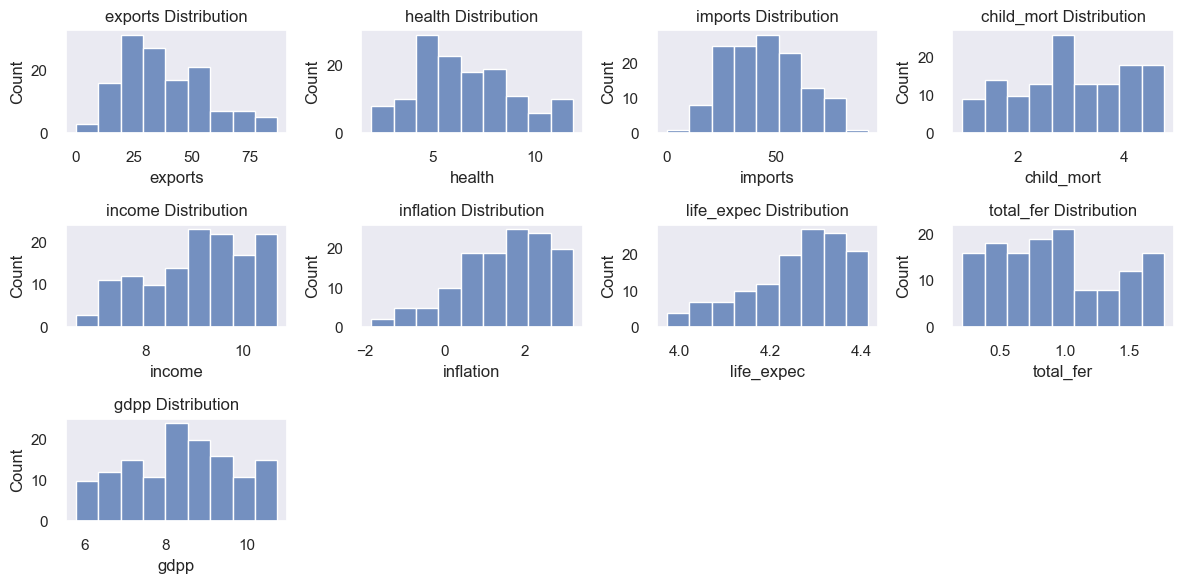

In [72]:
ML.plot_distribution_base(new_data_log.drop(columns='country'))

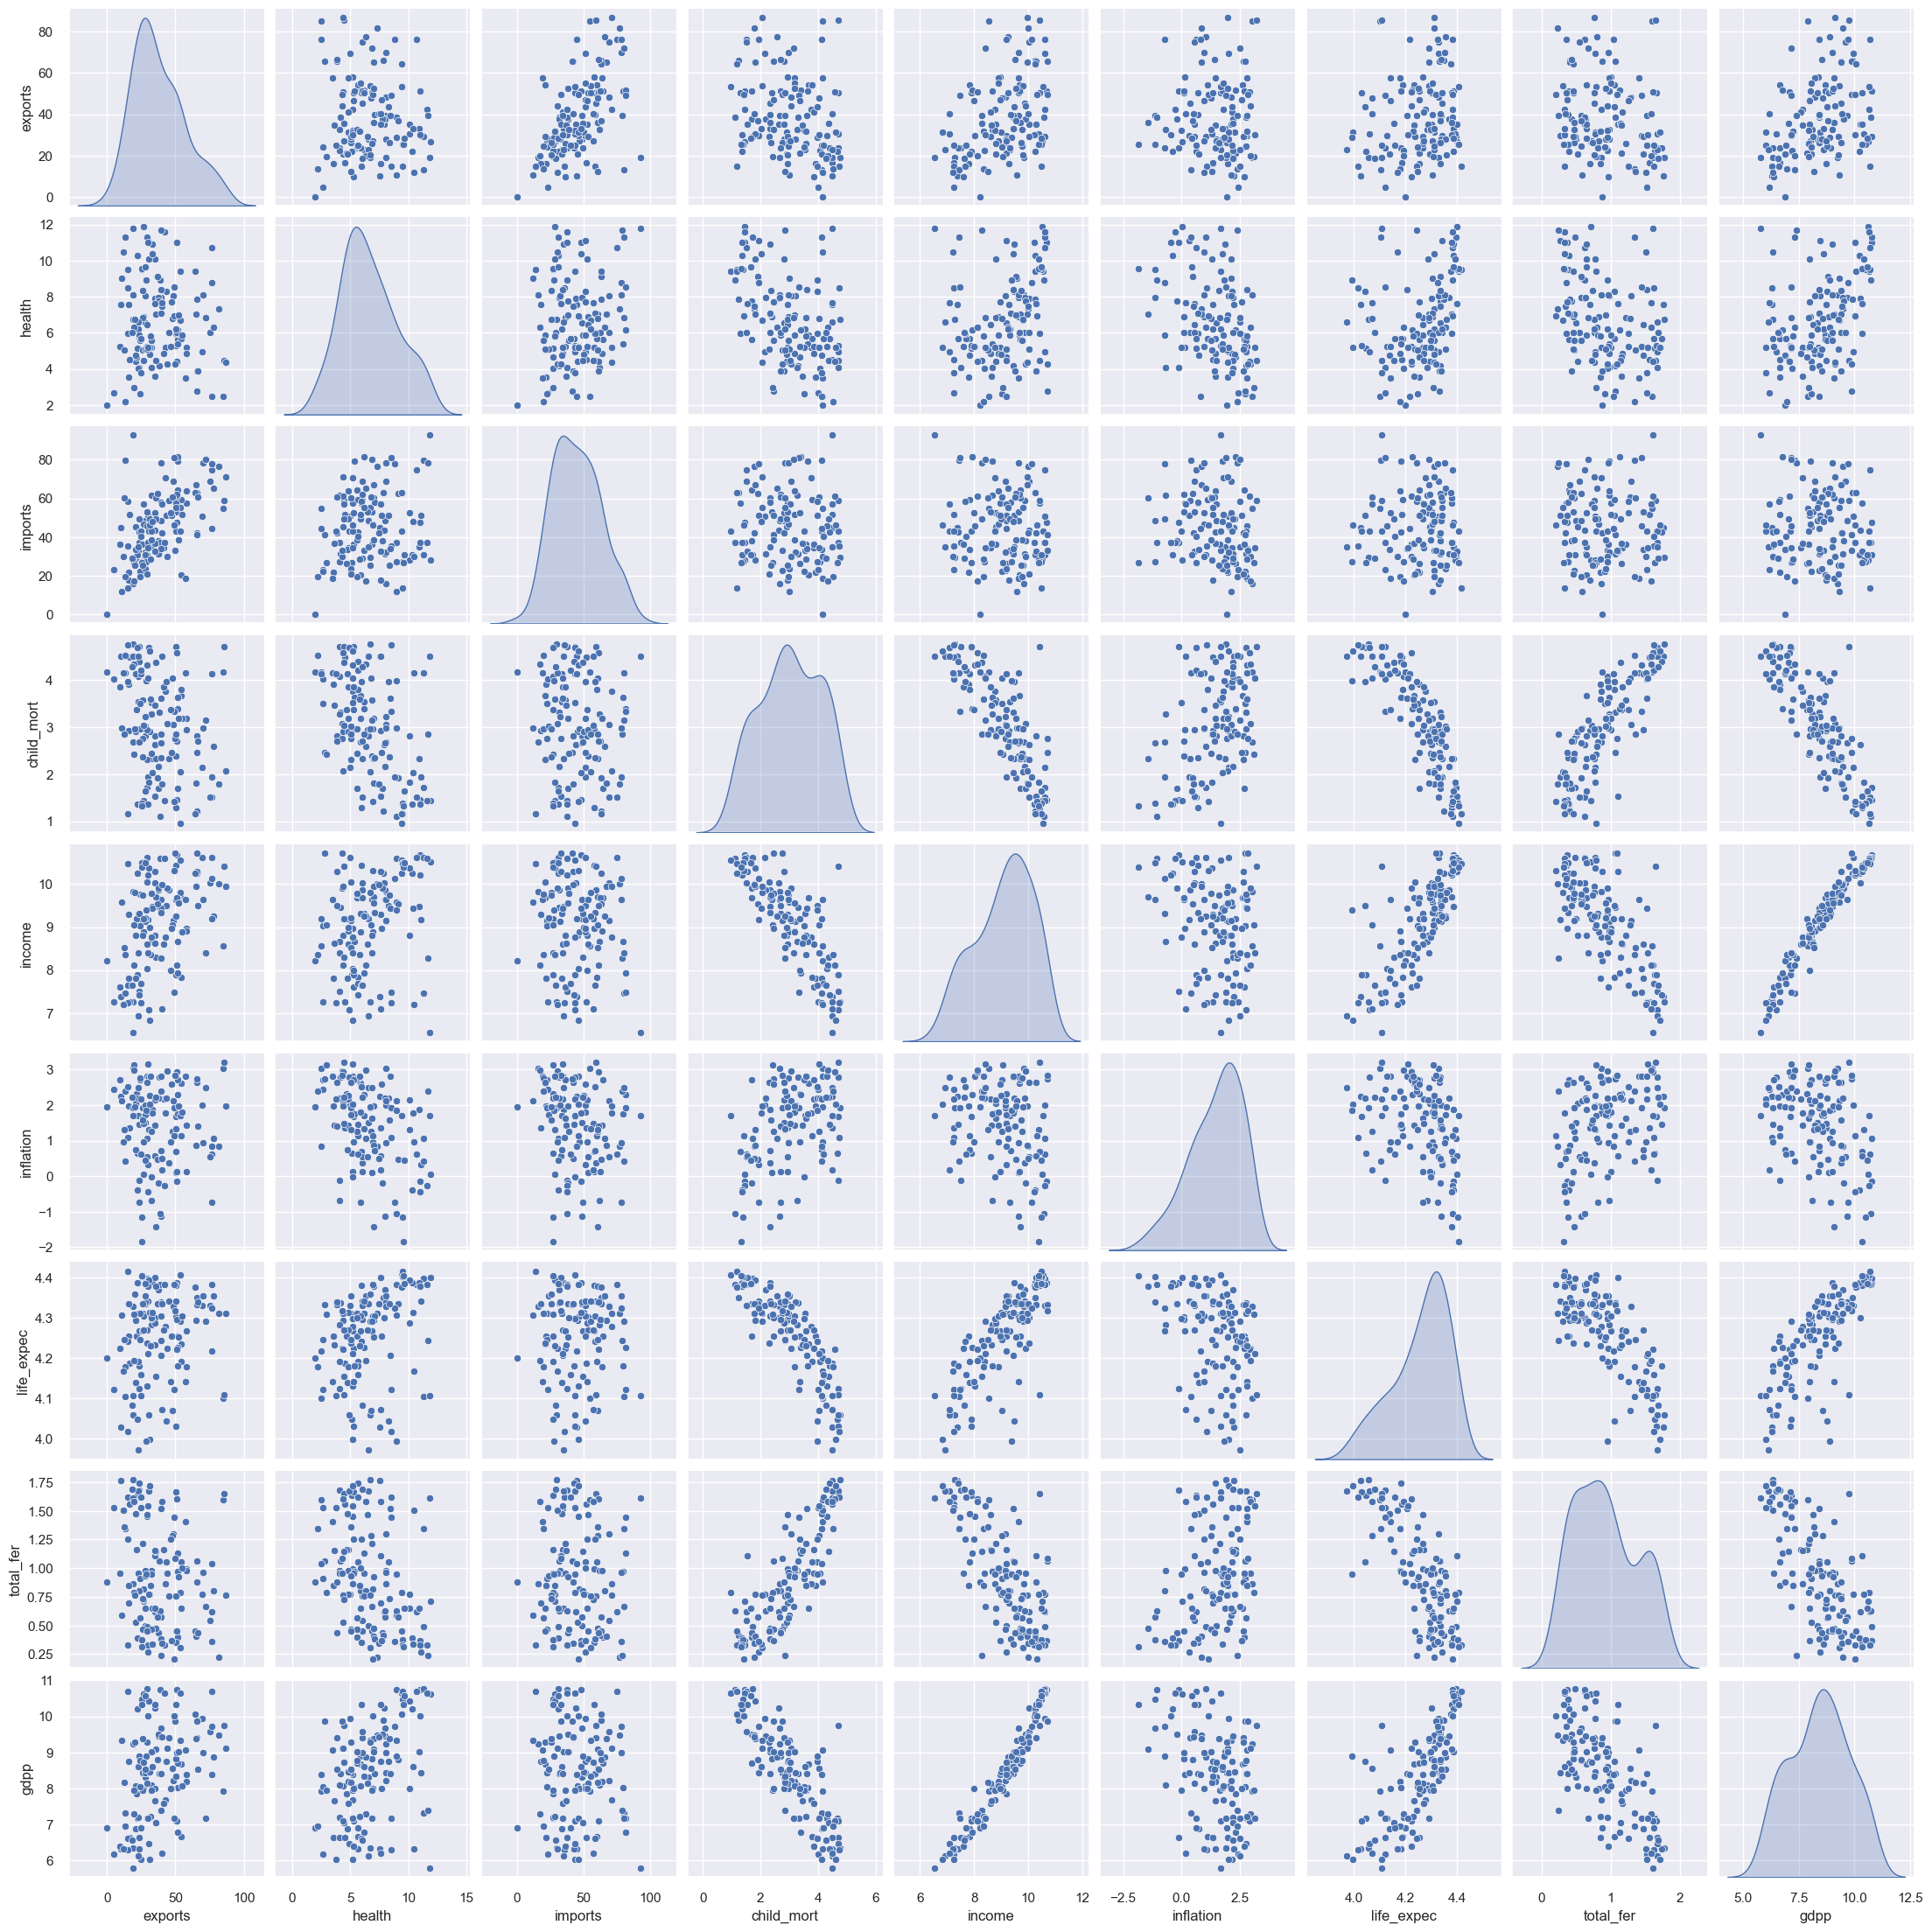

In [74]:
sns.pairplot(new_data_log, diag_kind="kde")

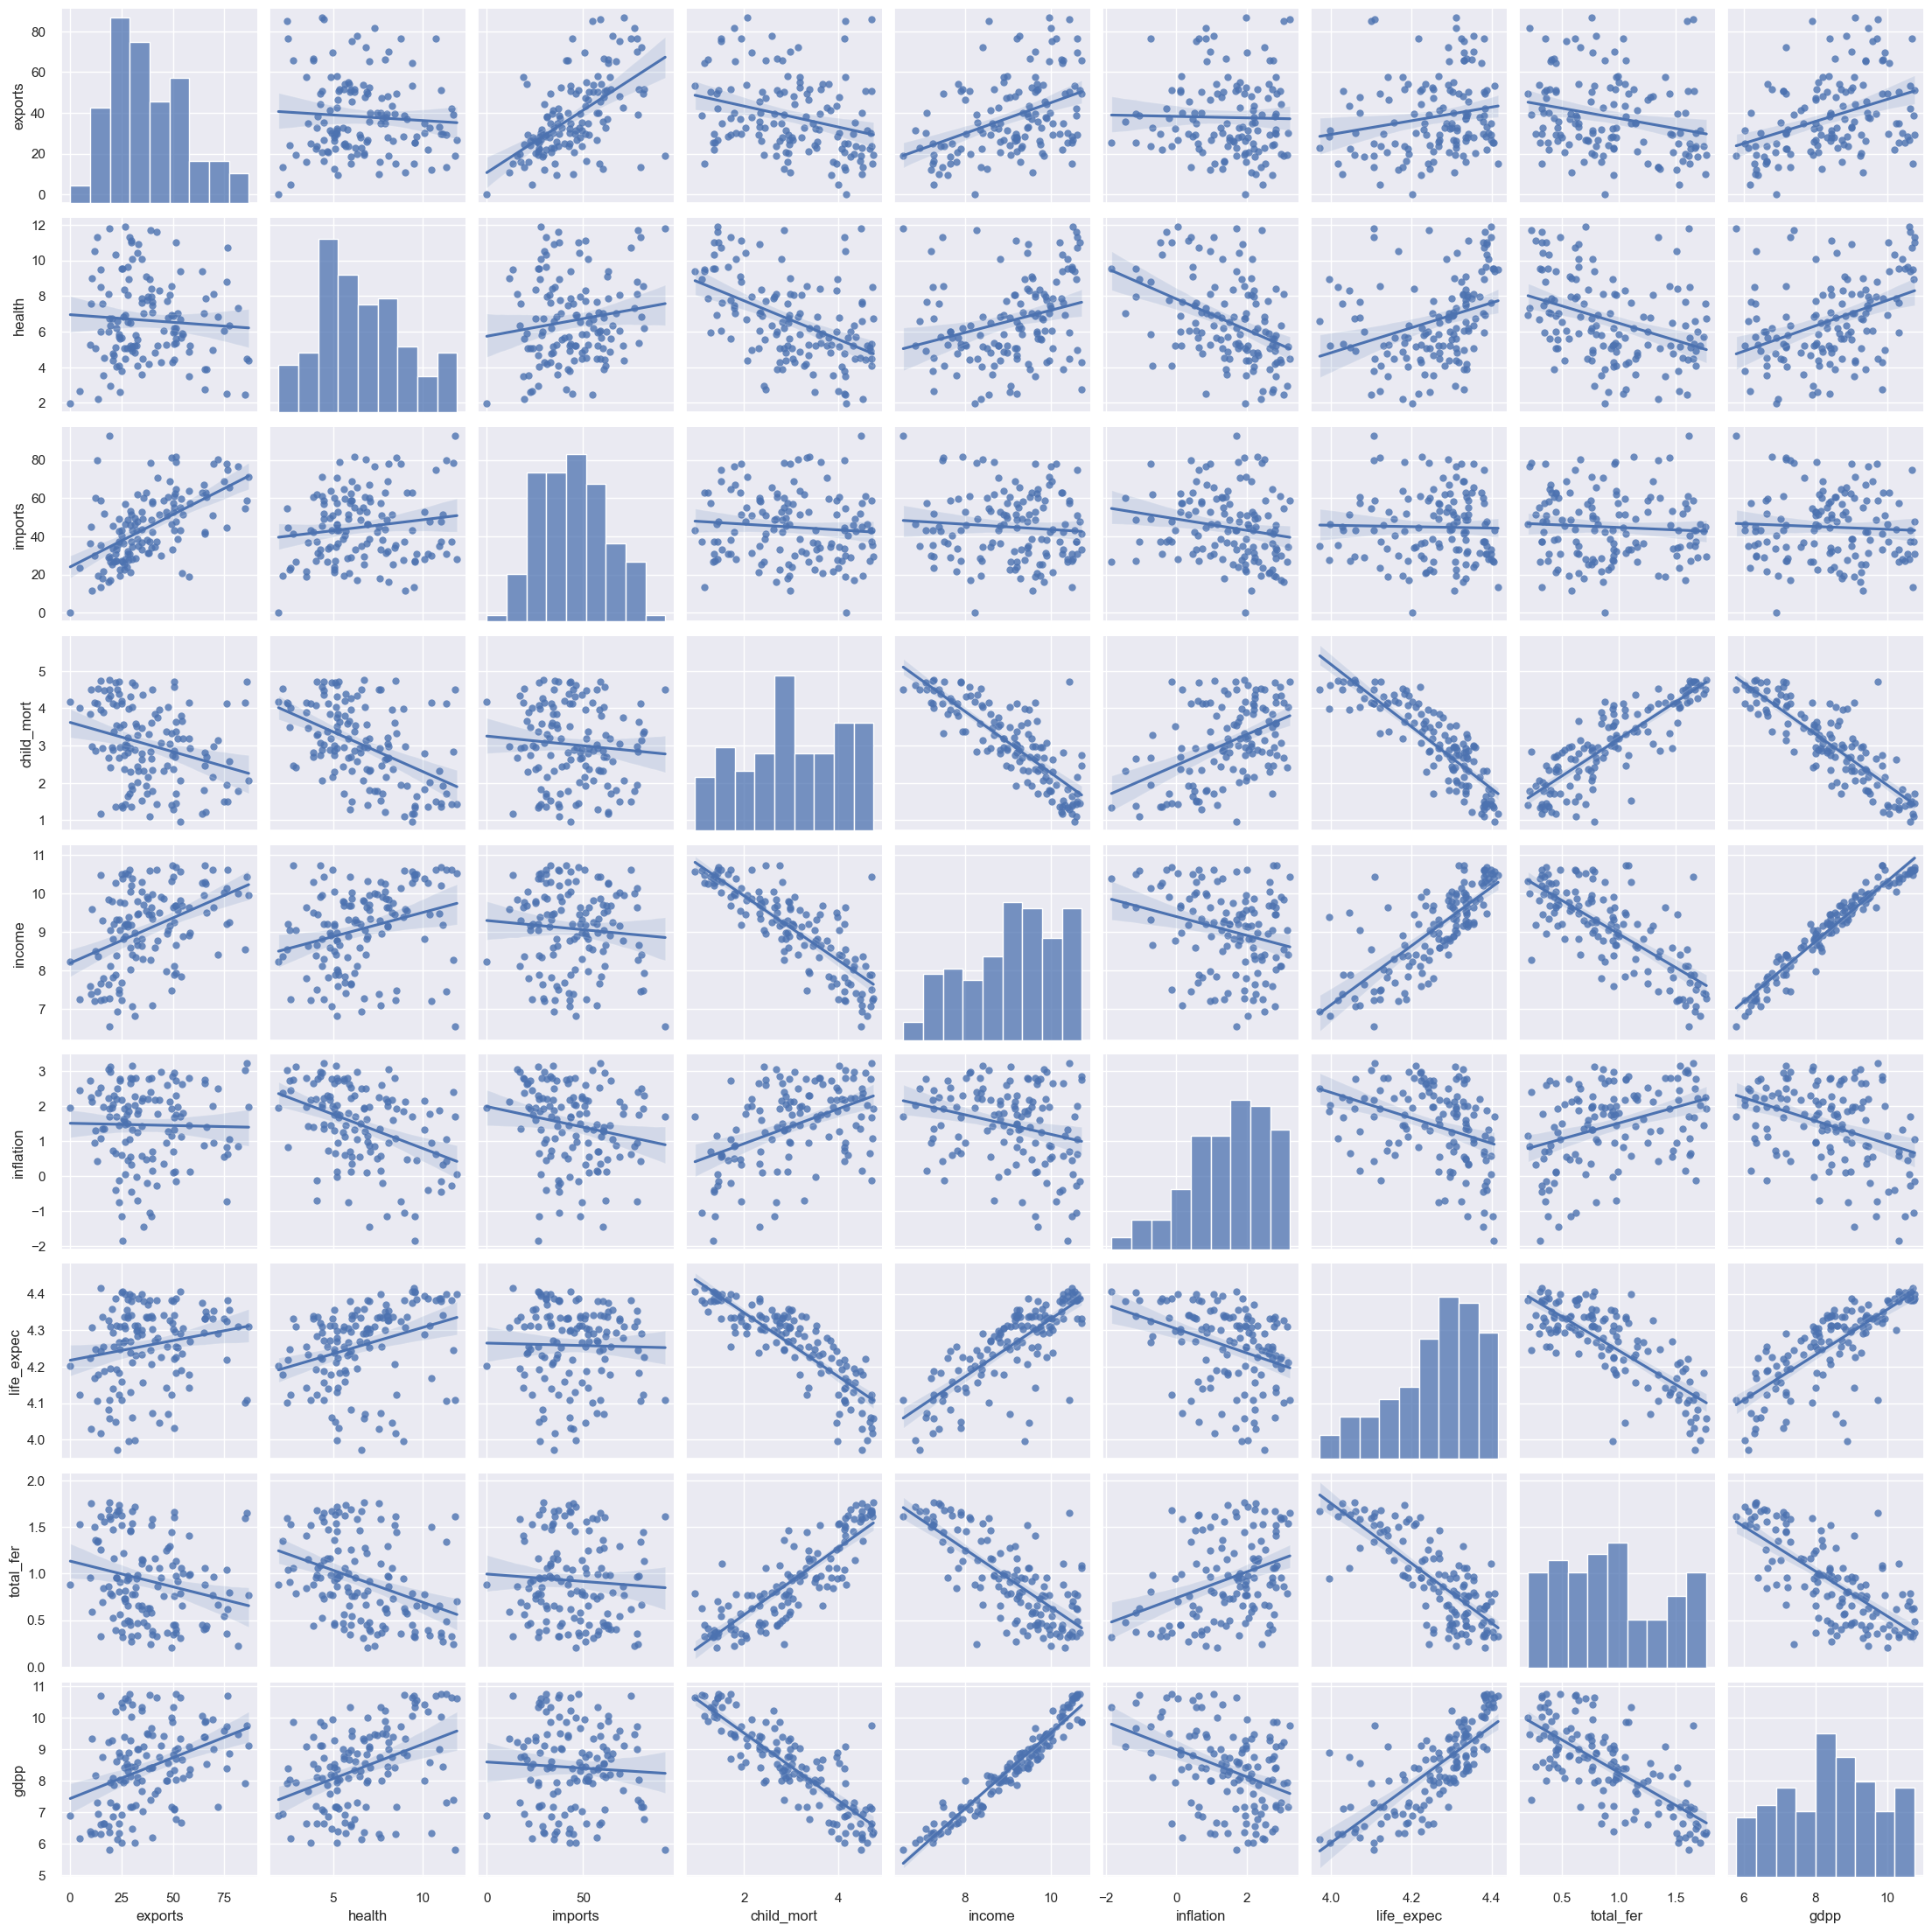

In [76]:
sns.pairplot(new_data_log, diag_kind="hist", kind = "reg")

In [79]:
scaler = StandardScaler()

scaled_data = pd.DataFrame(scaler.fit_transform(new_data.drop(columns='country')),
                           columns=new_data.drop(columns='country').columns,
                           index=new_data.drop(columns='country').index)
scaled_data

child_mort   exports    health   imports    income  inflation  \
0      1.802787 -1.483607  0.403345  0.003640 -1.027023   0.451493   
1     -0.539065 -0.532895 -0.032562  0.210275 -0.334162  -0.362135   
2     -0.198605  0.016405 -1.039802 -0.750298 -0.086830   1.546193   
3     -0.739522  0.391408 -0.252631  0.785502  0.429485  -0.863462   
4     -0.605884 -1.013532  0.623414 -1.610346  0.396174   2.335166   
..          ...       ...       ...       ...       ...        ...   
129   -0.729977 -0.622684  0.729217 -1.085382  0.262932  -0.293100   
130    0.087762 -0.337471 -0.345738 -0.912255 -0.808006   1.611941   
131   -0.138150  0.449507 -0.582735  0.439249 -0.915432  -0.669506   
132   -0.325880  1.791067  0.090169  1.975049 -0.787186   0.888716   
133    0.724135 -0.427260 -0.612360 -0.582756 -0.788019   2.778963   

     life_expec  total_fer      gdpp  
0     -2.031031   2.318455 -0.762246  
1      0.706348  -0.874728 -0.466313  
2      0.733586   0.074804 -0.435356  
3      0.774443  -0.507167  0.212233  
4      0.638254  -0.323387  0.053264  
..          ...        ...       ...  
129    0.719967  -0.545455  0.187132  
130   -0.315062  -0.346360 -0.693053  
131   -1.104953   0.541912 -0.560021  
132    0.270547  -0.645003 -0.698909  
133   -0.492106   1.437841 -0.698909  

[134 rows x 9 columns]

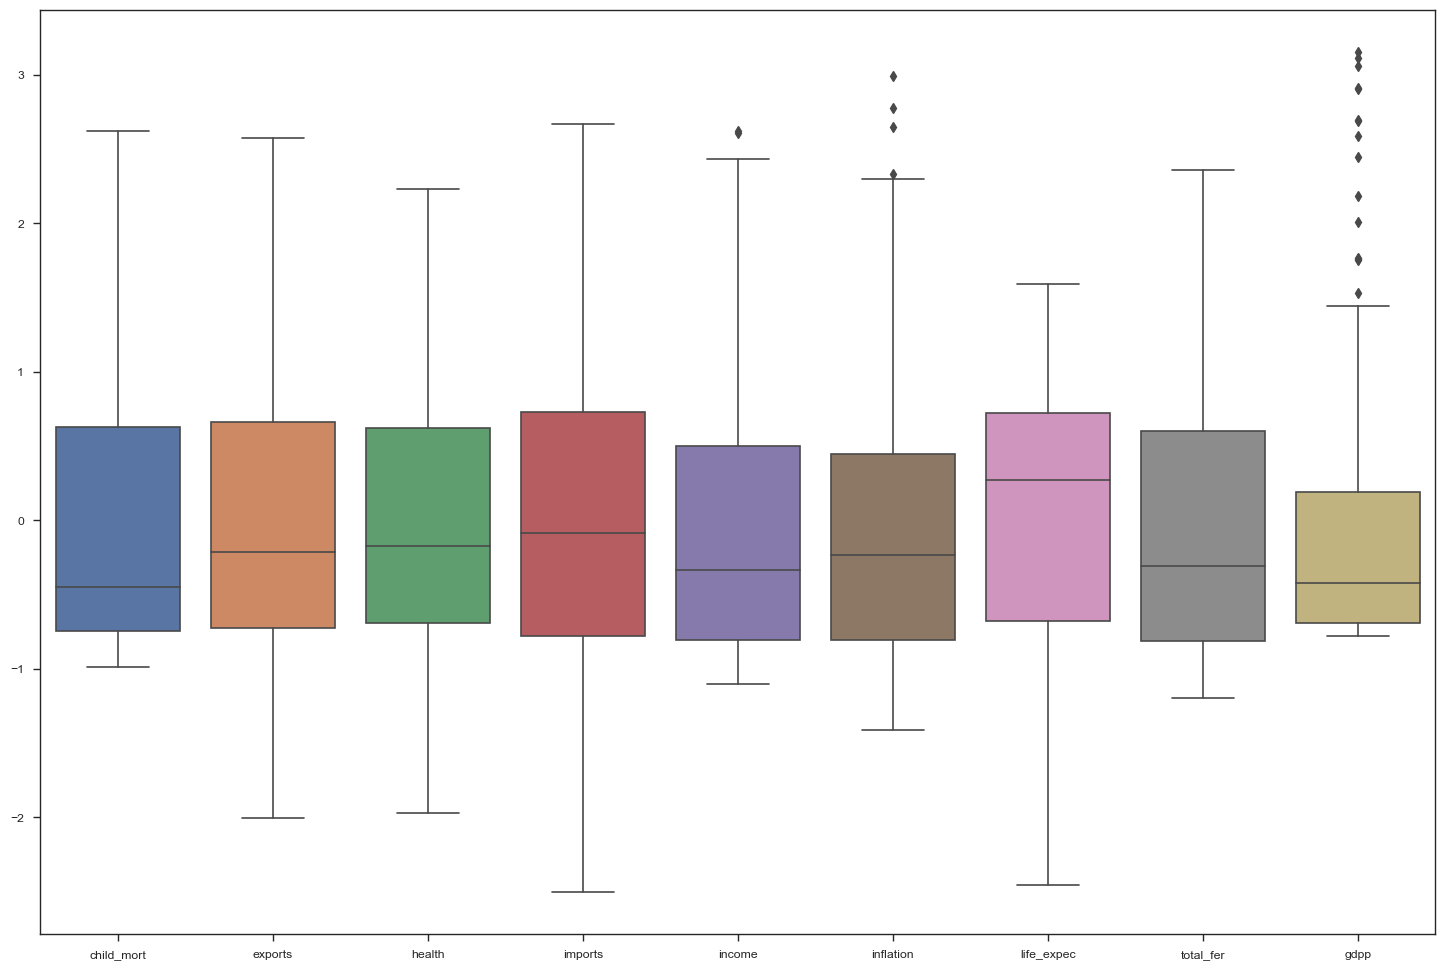

In [80]:
plt.figure(figsize=(18,12))
sns.boxplot(data=scaled_data);

<Axes: >

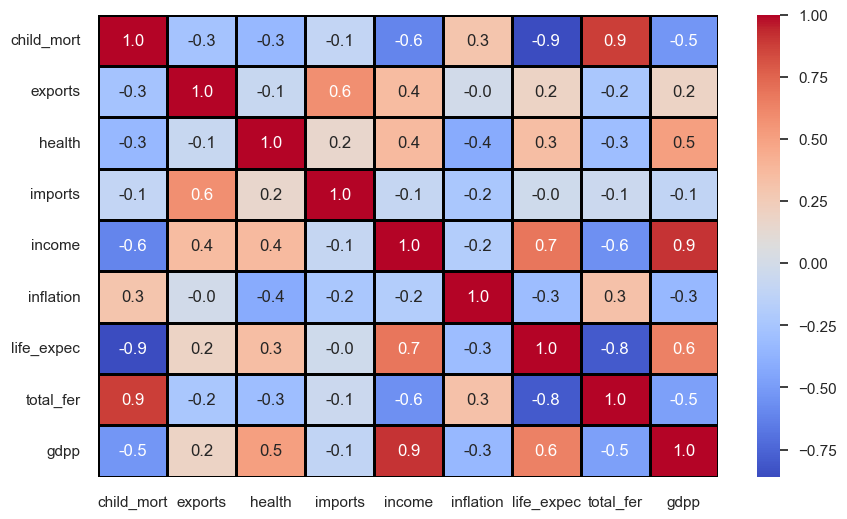

In [82]:
correlation = scaled_data.corr()
correlation
sns.set(rc = {'figure.figsize':(10,6)})
plot = sns.heatmap(correlation, annot = True, fmt=".1f", linewidths=1, linecolor='black',cmap ="coolwarm")
plot

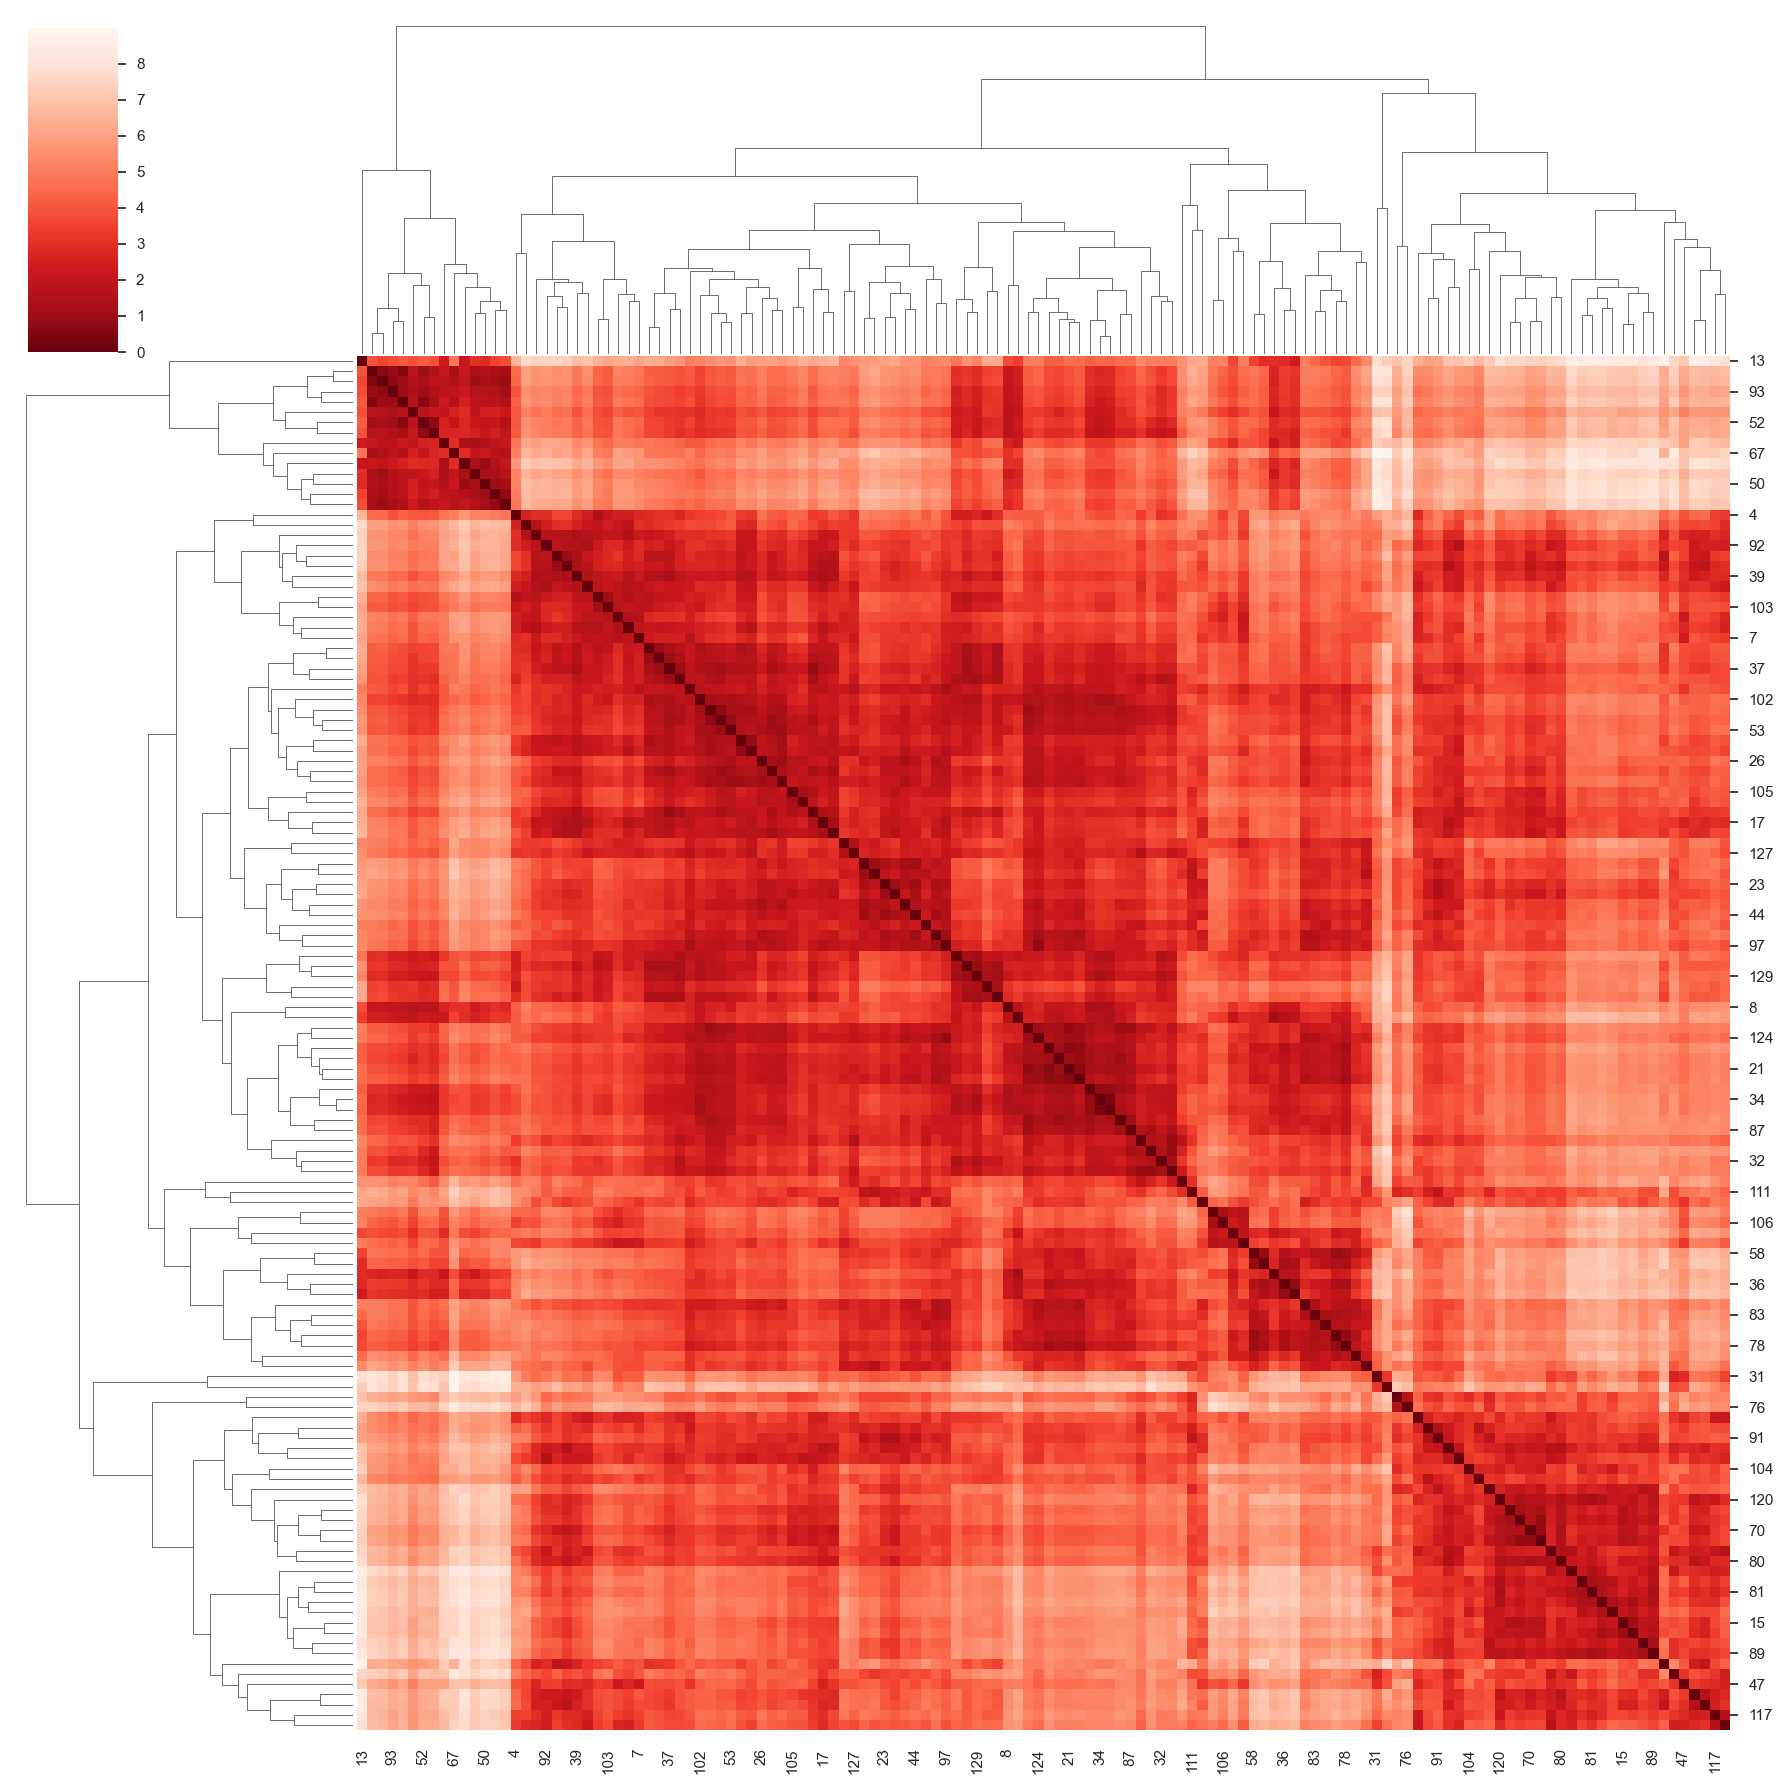

In [83]:
euclidean = DistanceMetric.get_metric('euclidean')

distances = euclidean.pairwise(scaled_data)
distances = pd.DataFrame(distances, 
                         columns=scaled_data.index,
                         index=scaled_data.index)

sns.clustermap(distances, cmap="Reds_r", figsize=(18, 18), method='average');

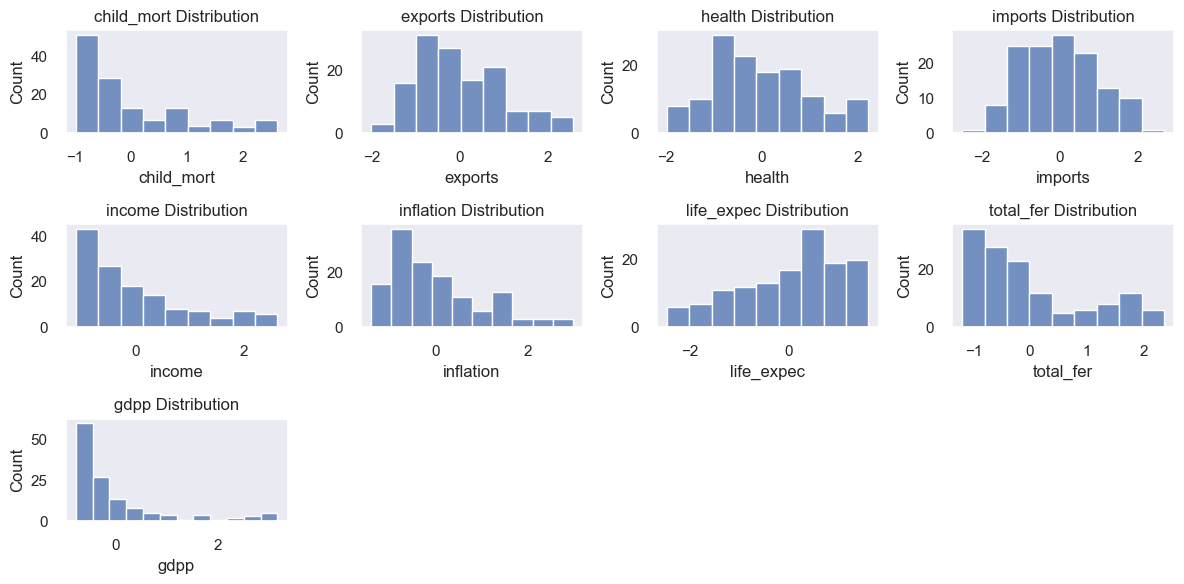

In [84]:
ML.plot_distribution_base(scaled_data)

# K Means Analysis

C:\Users\apmle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\apmle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\apmle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\U

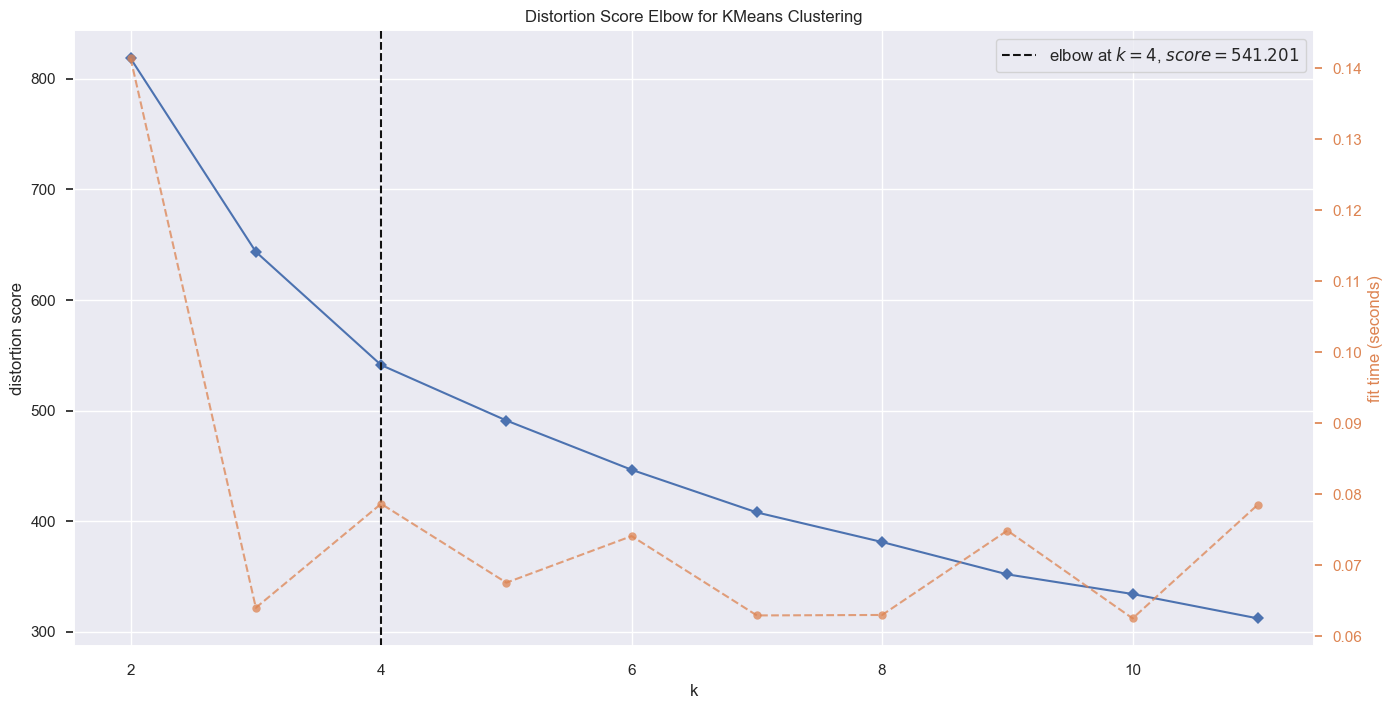

In [85]:
model = KMeans()

fig, ax =plt.subplots(1, 1, figsize=(16, 8))
visualizer = KElbowVisualizer(model, k=(2, 12), ax=ax)
visualizer.fit(scaled_data)
visualizer.show()

In [86]:
model = KMeans(n_clusters=4)
model.fit(scaled_data)
KM4 = model.predict(scaled_data)
KM4

C:\Users\apmle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([0, 2, 1, 2, 1, 1, 3, 1, 3, 3, 1, 2, 2, 3, 2, 0, 2, 1, 2, 0, 1, 2,
       0, 2, 0, 3, 2, 1, 1, 1, 0, 0, 2, 0, 2, 3, 2, 1, 1, 1, 2, 0, 0, 2,
       2, 3, 3, 0, 0, 2, 3, 0, 3, 2, 1, 0, 0, 2, 2, 3, 1, 1, 1, 0, 3, 3,
       1, 3, 2, 1, 0, 0, 2, 0, 2, 2, 0, 1, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2,
       2, 0, 1, 0, 1, 3, 1, 0, 2, 2, 1, 1, 2, 3, 1, 1, 0, 2, 1, 0, 2, 2,
       3, 2, 0, 3, 3, 1, 2, 0, 2, 0, 0, 2, 0, 2, 2, 1, 2, 2, 3, 1, 1, 2,
       2, 0])

In [87]:
model3 = KMeans(n_clusters=3)
model3.fit(scaled_data)
KM3 = model3.predict(scaled_data)
KM3

C:\Users\apmle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([1, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 0, 2, 1, 2, 2, 2, 1, 2, 2,
       1, 2, 1, 0, 2, 2, 2, 2, 1, 1, 2, 1, 2, 0, 0, 2, 2, 2, 2, 1, 1, 2,
       2, 0, 0, 1, 1, 2, 0, 1, 0, 2, 2, 1, 1, 2, 2, 0, 1, 2, 2, 1, 0, 0,
       2, 0, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2,
       2, 1, 1, 1, 1, 0, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 1, 2, 2,
       0, 1, 1, 0, 0, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 1])

In [88]:
data_groups = scaled_data.copy()  
data_groups["KM3"] = KM3
data_groups

child_mort   exports    health   imports    income  inflation  \
0      1.802787 -1.483607  0.403345  0.003640 -1.027023   0.451493   
1     -0.539065 -0.532895 -0.032562  0.210275 -0.334162  -0.362135   
2     -0.198605  0.016405 -1.039802 -0.750298 -0.086830   1.546193   
3     -0.739522  0.391408 -0.252631  0.785502  0.429485  -0.863462   
4     -0.605884 -1.013532  0.623414 -1.610346  0.396174   2.335166   
..          ...       ...       ...       ...       ...        ...   
129   -0.729977 -0.622684  0.729217 -1.085382  0.262932  -0.293100   
130    0.087762 -0.337471 -0.345738 -0.912255 -0.808006   1.611941   
131   -0.138150  0.449507 -0.582735  0.439249 -0.915432  -0.669506   
132   -0.325880  1.791067  0.090169  1.975049 -0.787186   0.888716   
133    0.724135 -0.427260 -0.612360 -0.582756 -0.788019   2.778963   

     life_expec  total_fer      gdpp  KM3  
0     -2.031031   2.318455 -0.762246    1  
1      0.706348  -0.874728 -0.466313    2  
2      0.733586   0.074804 -0.435356    2  
3      0.774443  -0.507167  0.212233    2  
4      0.638254  -0.323387  0.053264    2  
..          ...        ...       ...  ...  
129    0.719967  -0.545455  0.187132    2  
130   -0.315062  -0.346360 -0.693053    2  
131   -1.104953   0.541912 -0.560021    2  
132    0.270547  -0.645003 -0.698909    2  
133   -0.492106   1.437841 -0.698909    1  

[134 rows x 10 columns]

In [90]:
new_data["Cluster"] = KM3
new_data

country  child_mort  exports  health  imports  income  \
0            Afghanistan        90.2     10.0    7.58     44.9    1610   
1                Albania        16.6     28.0    6.55     48.6    9930   
2                Algeria        27.3     38.4    4.17     31.4   12900   
3    Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   
4              Argentina        14.5     18.9    8.10     16.0   18700   
..                   ...         ...      ...     ...      ...     ...   
129              Uruguay        10.6     26.3    8.35     25.4   17100   
130           Uzbekistan        36.3     31.7    5.81     28.5    4240   
131              Vanuatu        29.2     46.6    5.25     52.7    2950   
132              Vietnam        23.3     72.0    6.84     80.2    4490   
133                Yemen        56.3     30.0    5.18     34.4    4480   

     inflation  life_expec  total_fer   gdpp  Cluster  
0         9.44        56.2       5.82    553        1  
1         4.49        76.3       1.65   4090        2  
2        16.10        76.5       2.89   4460        2  
3         1.44        76.8       2.13  12200        2  
4        20.90        75.8       2.37  10300        2  
..         ...         ...        ...    ...      ...  
129       4.91        76.4       2.08  11900        2  
130      16.50        68.8       2.34   1380        2  
131       2.62        63.0       3.50   2970        2  
132      12.10        73.1       1.95   1310        2  
133      23.60        67.5       4.67   1310        1  

[134 rows x 11 columns]

In [91]:
vars = scaled_data.columns
vars

Index(['child_mort', 'exports', 'health', 'imports', 'income', 'inflation',
       'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

In [94]:
colors = ['green', 'blue', 'red']
dict_colors = dict(zip(set(KM3),colors))
dict_colors #Definindo as cores do Pairplot

{0: 'green', 1: 'blue', 2: 'red'}

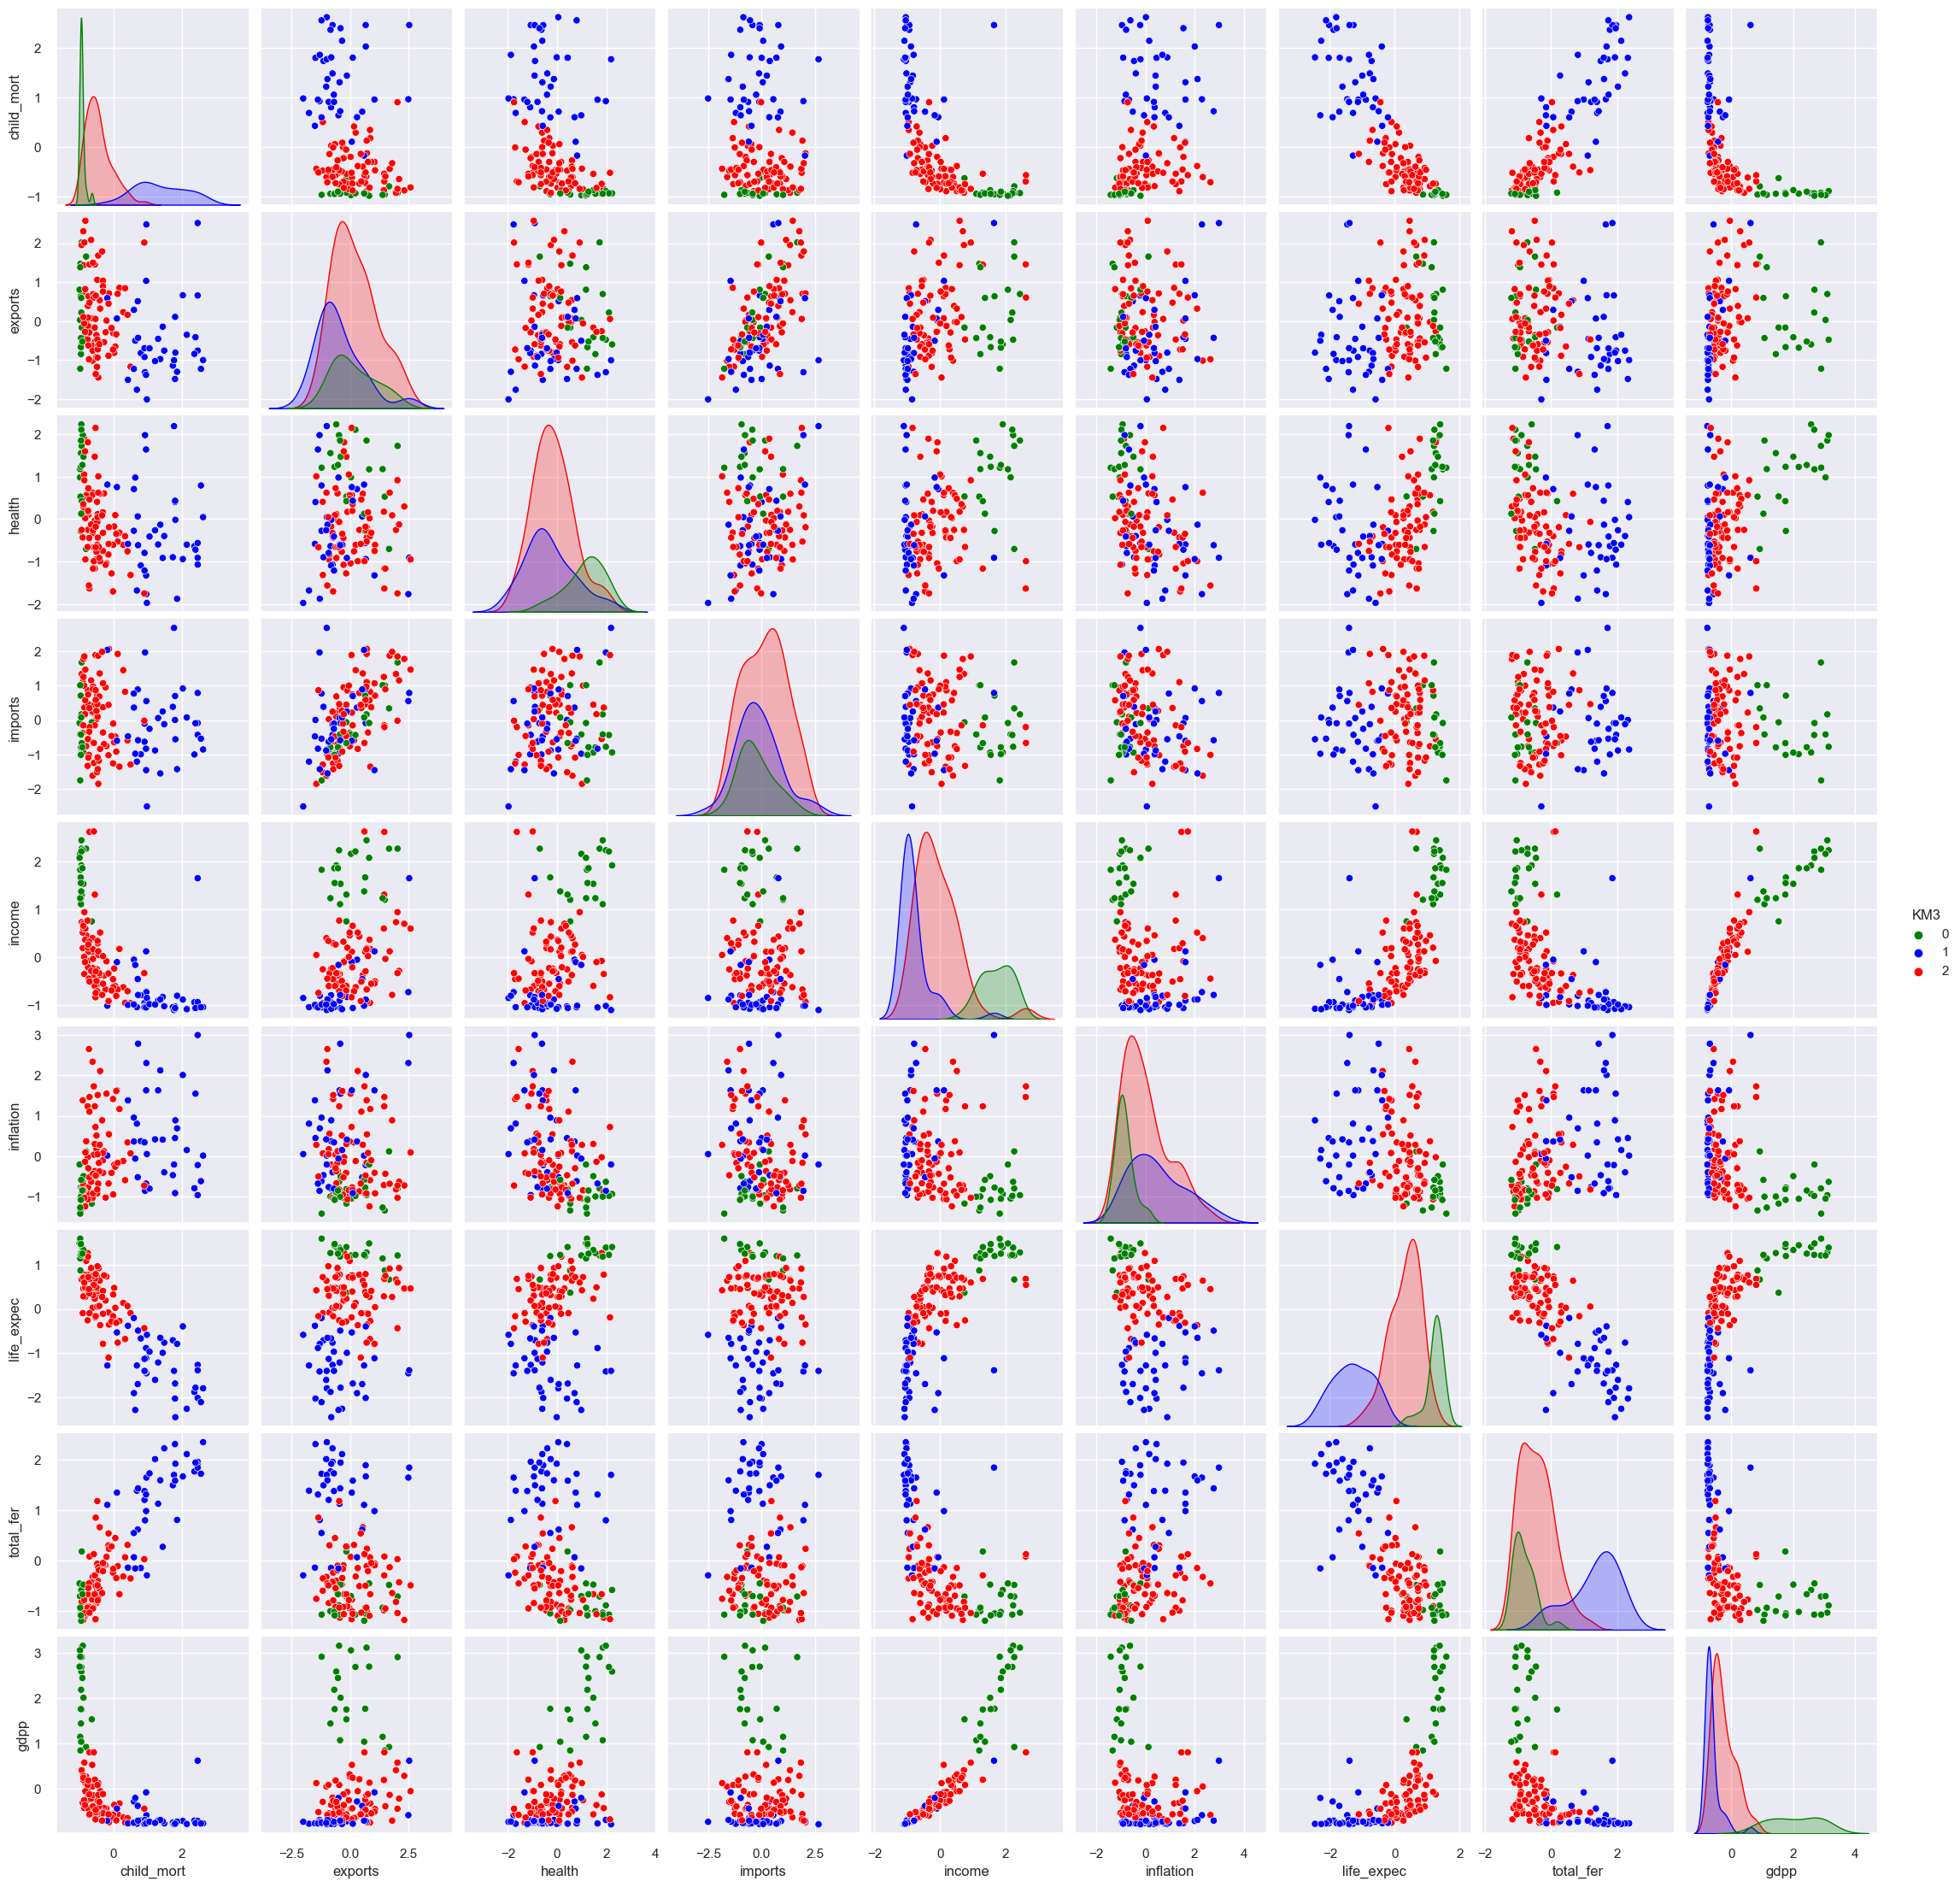

In [95]:
sns.pairplot(data=data_groups, x_vars=vars, y_vars=vars, hue='KM3', palette=dict_colors)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


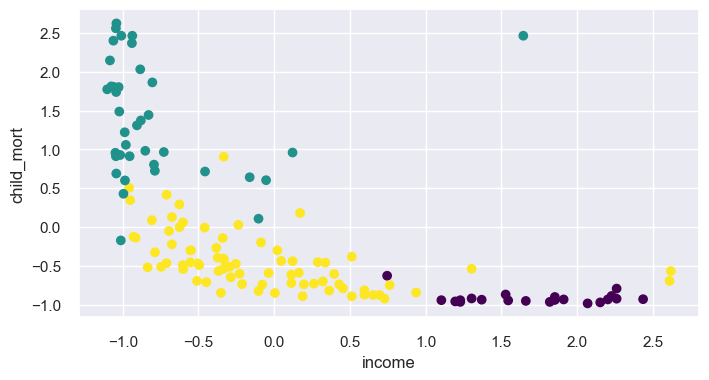

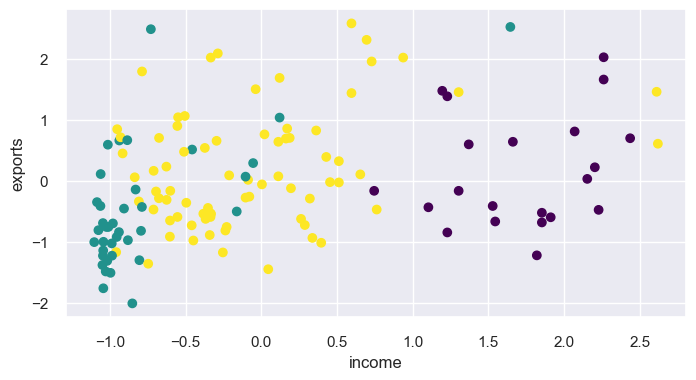

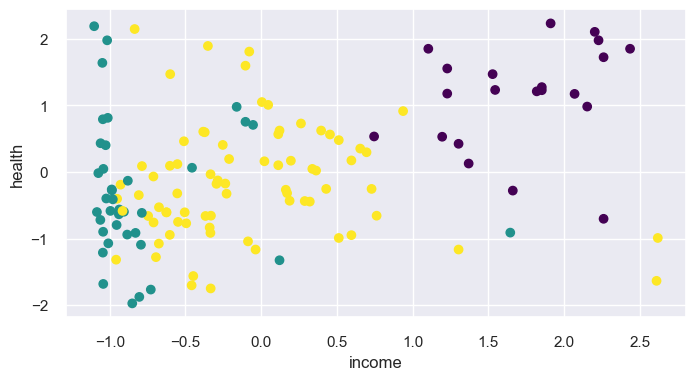

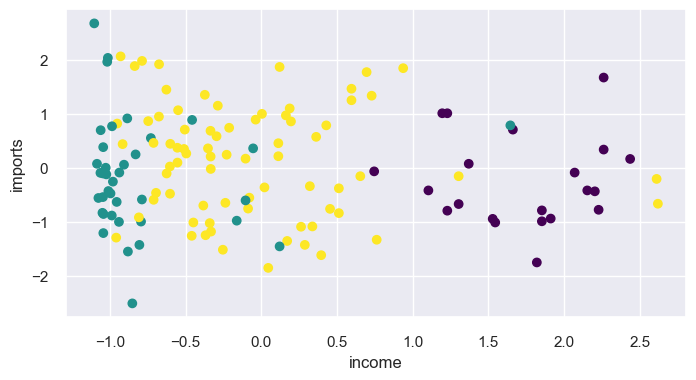

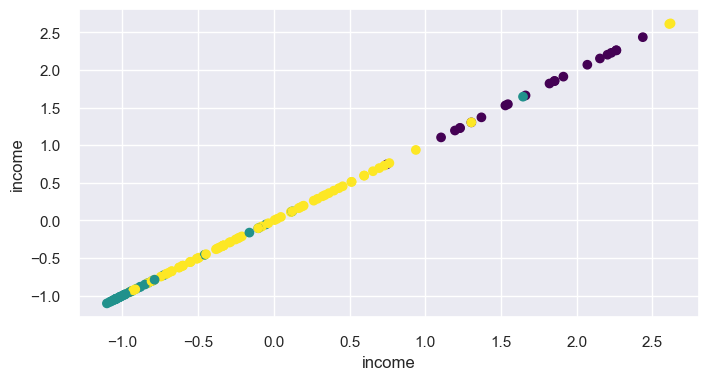

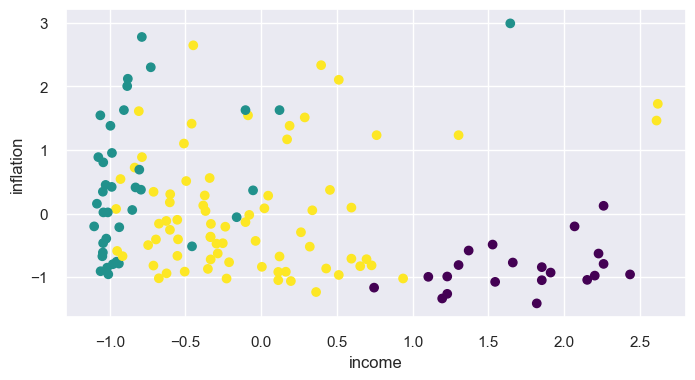

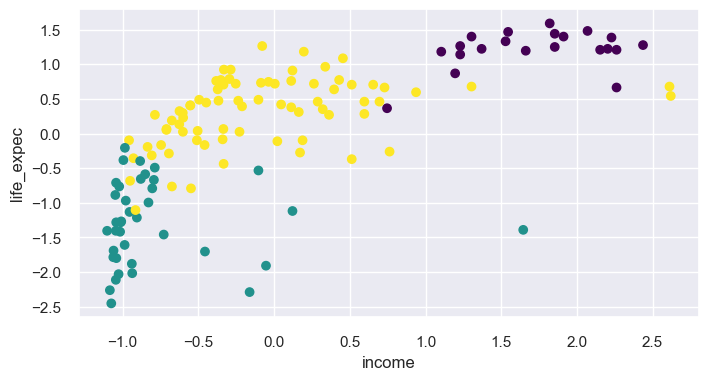

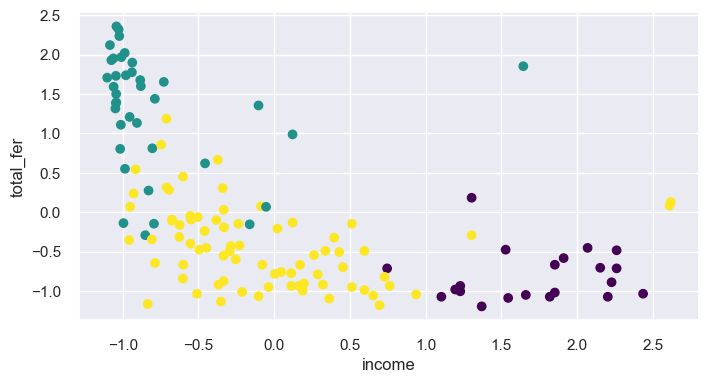

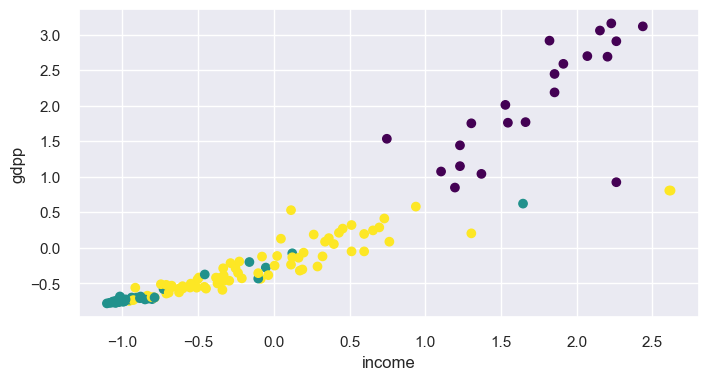

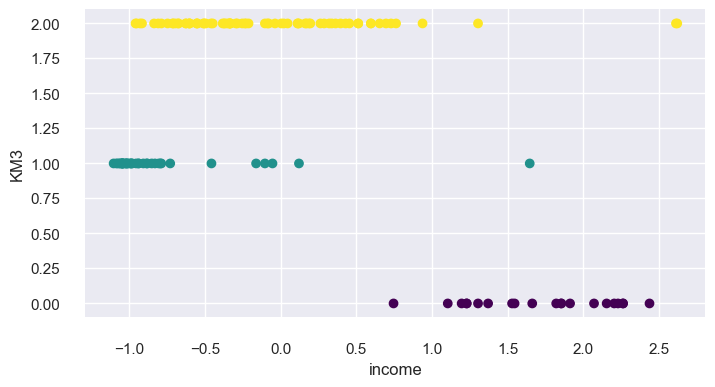

In [96]:
for coluna in data_groups.columns:
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.scatter(data_groups["income"],
    data_groups[coluna],
    c=KM3, cmap='viridis')
    ax.set_xlabel("income")
    ax.set_ylabel(coluna)        

ax.grid(True)
ax.legend()
sns.despine(offset=5)

## PCA Analysis

In [97]:
X = scaled_data

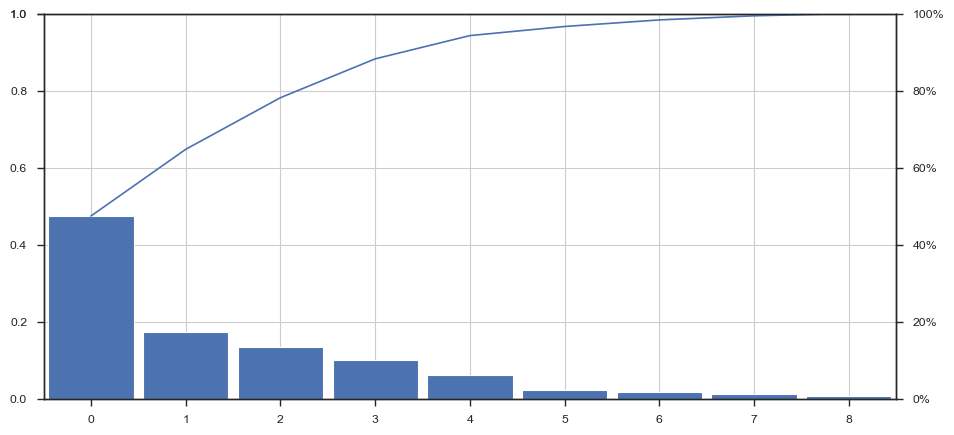

In [101]:
var, var_ratio, num_comp = ML.get_PCA_comp(X)

In [102]:
num_comp

4

In [107]:
pca = PCA(n_components=4)
data_pca = pca.fit_transform(X)

(<Figure size 1400x900 with 2 Axes>, <Axes: >, <Axes: >)

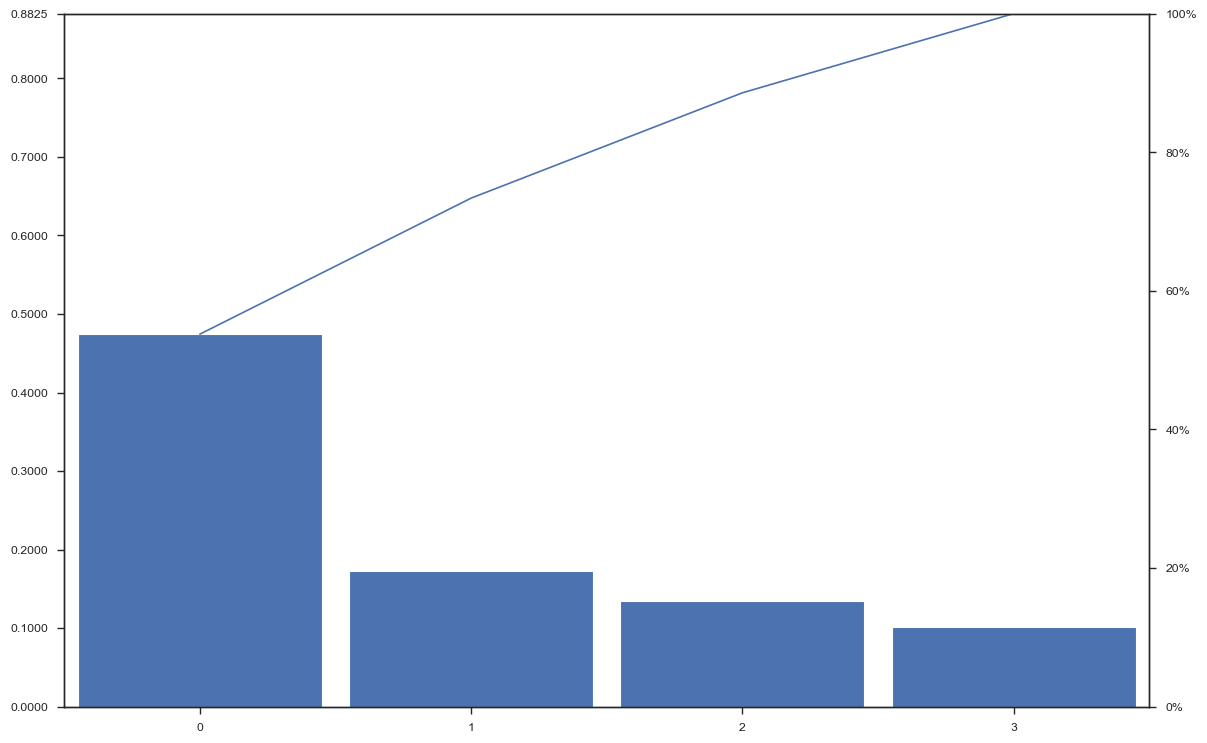

In [108]:
fig = plt.subplots(figsize=(14, 9))
pareto(pca.explained_variance_ratio_)

In [109]:
data_pca = pd.DataFrame(data_pca, columns=[f'COMP{i+1}' for i in range(data_pca.shape[1])])
data_pca

COMP1     COMP2     COMP3     COMP4
0   -3.531548  0.652763  1.491405  1.122234
1    0.563020  0.080399  0.185400 -1.361387
2   -0.489027  0.566104 -1.880731 -0.418530
3    1.338184 -0.790004  0.088514 -0.505835
4    0.250864  2.155846 -1.479754 -0.021325
..        ...       ...       ...       ...
129  1.127983  1.321850  0.218834 -0.512128
130 -1.184471  0.762678 -1.172261 -0.626937
131 -1.143306 -0.997840  0.433887 -0.370529
132  0.124717 -2.682823 -0.655215 -0.567020
133 -2.575826  0.672425 -1.597171  0.564114

[134 rows x 4 columns]

In [111]:
model = KMeans(n_clusters=3)
model.fit(data_pca)
clusters_pca = model.predict(data_pca)
new_data['cluster_pca'] = clusters_pca
new_data

C:\Users\apmle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


country  child_mort  exports  health  imports  income  \
0            Afghanistan        90.2     10.0    7.58     44.9    1610   
1                Albania        16.6     28.0    6.55     48.6    9930   
2                Algeria        27.3     38.4    4.17     31.4   12900   
3    Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   
4              Argentina        14.5     18.9    8.10     16.0   18700   
..                   ...         ...      ...     ...      ...     ...   
129              Uruguay        10.6     26.3    8.35     25.4   17100   
130           Uzbekistan        36.3     31.7    5.81     28.5    4240   
131              Vanuatu        29.2     46.6    5.25     52.7    2950   
132              Vietnam        23.3     72.0    6.84     80.2    4490   
133                Yemen        56.3     30.0    5.18     34.4    4480   

     inflation  life_expec  total_fer   gdpp  Cluster  cluster_pca  
0         9.44        56.2       5.82    553        1            1  
1         4.49        76.3       1.65   4090        2            0  
2        16.10        76.5       2.89   4460        2            0  
3         1.44        76.8       2.13  12200        2            0  
4        20.90        75.8       2.37  10300        2            0  
..         ...         ...        ...    ...      ...          ...  
129       4.91        76.4       2.08  11900        2            0  
130      16.50        68.8       2.34   1380        2            0  
131       2.62        63.0       3.50   2970        2            0  
132      12.10        73.1       1.95   1310        2            0  
133      23.60        67.5       4.67   1310        1            1  

[134 rows x 12 columns]

In [113]:
(new_data['Cluster'] != new_data['cluster_pca']).sum()

95

In [114]:
centers = pd.DataFrame(model.cluster_centers_, columns=[f'V{i+1}' for i in range(data_pca.shape[1])])
centers

V1        V2        V3        V4
0  0.325652 -0.250207 -0.294690 -0.590507
1 -2.501038  0.164798  0.355818  0.619246
2  3.224598  0.556956  0.376635  0.916645

In [115]:
data_pca['cluster'] = clusters_pca
data_pca

COMP1     COMP2     COMP3     COMP4  cluster
0   -3.531548  0.652763  1.491405  1.122234        1
1    0.563020  0.080399  0.185400 -1.361387        0
2   -0.489027  0.566104 -1.880731 -0.418530        0
3    1.338184 -0.790004  0.088514 -0.505835        0
4    0.250864  2.155846 -1.479754 -0.021325        0
..        ...       ...       ...       ...      ...
129  1.127983  1.321850  0.218834 -0.512128        0
130 -1.184471  0.762678 -1.172261 -0.626937        0
131 -1.143306 -0.997840  0.433887 -0.370529        0
132  0.124717 -2.682823 -0.655215 -0.567020        0
133 -2.575826  0.672425 -1.597171  0.564114        1

[134 rows x 5 columns]

## Cluster #1

In [121]:
cluster_0 = data_pca[data_pca['cluster']==0]
cluster_0

COMP1     COMP2     COMP3     COMP4  cluster
1    0.563020  0.080399  0.185400 -1.361387        0
2   -0.489027  0.566104 -1.880731 -0.418530        0
3    1.338184 -0.790004  0.088514 -0.505835        0
4    0.250864  2.155846 -1.479754 -0.021325        0
5   -0.213095  0.355704 -0.482970 -1.596247        0
..        ...       ...       ...       ...      ...
127  0.211577 -0.610115 -0.645476 -0.797426        0
129  1.127983  1.321850  0.218834 -0.512128        0
130 -1.184471  0.762678 -1.172261 -0.626937        0
131 -1.143306 -0.997840  0.433887 -0.370529        0
132  0.124717 -2.682823 -0.655215 -0.567020        0

[74 rows x 5 columns]

In [124]:
# Rename the columns in the centers DataFrame to match the column names in cluster_0
centers.columns = ['COMP1', 'COMP2', 'COMP3', 'COMP4']

# Calculate the dist_2 column in cluster_0
cluster_number = 0  # Replace 0 with the actual cluster number
if cluster_number in centers.index:
    cluster_0['dist_2'] = (cluster_0['COMP1'] - centers.loc[cluster_number]['COMP1'])**2 + \
                         (cluster_0['COMP2'] - centers.loc[cluster_number]['COMP2'])**2 + \
                         (cluster_0['COMP3'] - centers.loc[cluster_number]['COMP3'])**2 + \
                         (cluster_0['COMP4'] - centers.loc[cluster_number]['COMP4'])**2
else:
    print(f"Cluster {cluster_number} not found in centers DataFrame.")

C:\Users\apmle\AppData\Local\Temp\ipykernel_23948\2227890396.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_0['dist_2'] = (cluster_0['COMP1'] - centers.loc[cluster_number]['COMP1'])**2 + \


In [125]:
index_min = cluster_0['dist_2'][cluster_0['dist_2'] == cluster_0['dist_2'].min()].index

## Best Country to Represent CLUSTER #1

In [126]:
new_data.iloc[index_min,:]

country  child_mort  exports  health  imports  income  inflation  \
127  Ukraine        11.7     47.1    7.72     51.1    7820       13.4   

     life_expec  total_fer  gdpp  Cluster  cluster_pca  
127        70.4       1.44  2970        2            0

## Cluster #2

In [127]:
cluster_1 = data_pca[data_pca['cluster']==1]
cluster_1

COMP1     COMP2     COMP3     COMP4  cluster
0   -3.531548  0.652763  1.491405  1.122234        1
15  -3.306090  0.360290  1.134105  0.688962        1
19  -1.068981 -0.576972  0.540998  0.842148        1
22  -3.761915  0.948063  1.300789  1.384446        1
24  -3.368910  0.832734  1.206090  0.883740        1
30  -2.668250  0.093841  0.991540  0.060021        1
31  -2.787570 -2.187377 -2.432215  1.490663        1
33  -3.344719 -0.739023  0.667881  1.501429        1
41  -1.943032 -1.770442 -2.553631  4.110587        1
42  -3.098036  1.605163 -0.530465 -0.346803        1
47  -1.883890  0.364597 -2.059650  1.380687        1
48  -2.727669  0.254855  1.065074  0.541848        1
51  -2.772636  0.057774 -0.528900  0.555195        1
55  -3.914174  0.082769 -0.209955  1.344193        1
56  -3.302914  0.831677  2.226055  1.142711        1
60  -1.718341  0.948747 -0.503427 -0.681158        1
63  -1.218129  0.469706 -0.467465  0.983581        1
70  -2.259204  0.622390  0.809131 -0.178798        1
71  -1.421636 -0.837226  3.203141  0.144942        1
73  -2.116715 -0.385410 -0.143564  0.001624        1
76  -2.220487 -1.471882  3.245407  1.000579        1
80  -2.795987  0.115218  0.000447  0.047295        1
81  -3.708442  0.589169  0.640455  1.203621        1
84  -2.896670 -1.170667 -1.063896  1.150528        1
89  -3.737604 -0.245370  0.819207  1.219058        1
90  -2.158130  2.709344 -0.779208 -1.274754        1
91  -1.366623 -1.256313  0.925464  0.605747        1
92  -1.721352  1.117167 -0.561623 -0.922306        1
95  -2.996953  1.552051 -0.795819 -0.082802        1
104 -1.729640  1.270105  2.269450  0.200145        1
107 -2.310424  0.256610  1.151739  0.191987        1
111 -1.216467 -2.130433  1.248109  0.226766        1
112 -1.198108  0.853919  0.959869  0.642455        1
117 -2.878764  1.699077 -0.790834  0.753771        1
119 -1.707392  0.049801  0.184218 -0.538938        1
120 -3.096828  0.978902  0.578490  0.682801        1
122 -2.509392 -0.955723  1.879862  0.889016        1
133 -2.575826  0.672425 -1.597171  0.564114        1

In [128]:
# Rename the columns in the centers DataFrame to match the column names in cluster_0
centers.columns = ['COMP1', 'COMP2', 'COMP3', 'COMP4']

# Calculate the dist_2 column in cluster_0
cluster_number = 1  # Replace 0 with the actual cluster number
if cluster_number in centers.index:
    cluster_1['dist_2'] = (cluster_1['COMP1'] - centers.loc[cluster_number]['COMP1'])**2 + \
                         (cluster_1['COMP2'] - centers.loc[cluster_number]['COMP2'])**2 + \
                         (cluster_1['COMP3'] - centers.loc[cluster_number]['COMP3'])**2 + \
                         (cluster_1['COMP4'] - centers.loc[cluster_number]['COMP4'])**2
else:
    print(f"Cluster {cluster_number} not found in centers DataFrame.")

C:\Users\apmle\AppData\Local\Temp\ipykernel_23948\1308808091.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_1['dist_2'] = (cluster_1['COMP1'] - centers.loc[cluster_number]['COMP1'])**2 + \


In [129]:
index_min_cluster1 = cluster_1['dist_2'][cluster_1['dist_2'] == cluster_1['dist_2'].min()].index

## Best Country to Represent CLUSTER #2

In [130]:
data.iloc[index_min_cluster1,:]

country  child_mort  exports  health  imports  income  inflation  \
80   Kenya        62.2     20.7    4.75     33.6    2480       2.09   

    life_expec  total_fer  gdpp  
80        62.8       4.37   967

## Cluster #3

In [131]:
cluster_2 = data_pca[data_pca['cluster']==2]
cluster_2

COMP1     COMP2     COMP3     COMP4  cluster
6    4.413715  0.371802  0.610211  1.962921        2
8    1.997124  0.447939  0.728134  0.335459        2
9    2.177197 -0.930967 -1.655556  1.110448        2
13   4.310843 -1.620137  0.445838  2.265699        2
25   4.044000  1.839418  0.685483  1.733240        2
35   2.958979 -0.461204 -0.464973  0.481442        2
36   2.723906 -1.433408  0.293992  0.218187        2
45   3.786804  1.100418  0.345831  1.580434        2
46   3.696238  1.900274  1.108901  1.398496        2
50   4.109095  1.024847  0.820431  1.577719        2
52   2.881764  1.607747  0.939265  0.131231        2
59   3.633232  0.409391 -0.246211  1.793087        2
64   2.381486  1.096912  0.124980  0.784119        2
65   3.456986  1.824205  0.553074  0.702399        2
67   3.783741  2.828465  0.762435  0.786323        2
93   2.942087  1.621954  0.425718  0.982870        2
101  2.840195  1.010402  1.088064  0.047544        2
109  2.529285 -2.423967  0.430897  0.316865        2
110  3.098299 -1.236549  0.619226  0.467350        2
113  2.642929 -0.080218 -0.464340  0.046009        2
114  3.212789  1.725381  0.599917  0.312349        2
128  3.320475  1.630328  0.534648  1.131995        2

In [132]:
# Rename the columns in the centers DataFrame to match the column names in cluster_0
centers.columns = ['COMP1', 'COMP2', 'COMP3', 'COMP4']

# Calculate the dist_2 column in cluster_0
cluster_number = 2  # Replace 0 with the actual cluster number
if cluster_number in centers.index:
    cluster_2['dist_2'] = (cluster_2['COMP1'] - centers.loc[cluster_number]['COMP1'])**2 + \
                         (cluster_2['COMP2'] - centers.loc[cluster_number]['COMP2'])**2 + \
                         (cluster_2['COMP3'] - centers.loc[cluster_number]['COMP3'])**2 + \
                         (cluster_2['COMP4'] - centers.loc[cluster_number]['COMP4'])**2
else:
    print(f"Cluster {cluster_number} not found in centers DataFrame.")

C:\Users\apmle\AppData\Local\Temp\ipykernel_23948\347369137.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_2['dist_2'] = (cluster_2['COMP1'] - centers.loc[cluster_number]['COMP1'])**2 + \


In [133]:
index_min_cluster2 = cluster_2['dist_2'][cluster_2['dist_2'] == cluster_2['dist_2'].min()].index

## Best Country to Represent CLUSTER #3

In [134]:
data.iloc[index_min_cluster2,:]

country  child_mort  exports  health  imports  income  \
45  Dominican Republic        34.4     22.7    6.22     33.3   11100   

    inflation  life_expec  total_fer  gdpp  
45       5.44        74.6        2.6  5450

## Hierarchical Clustering

In [136]:
X = scaled_data[["income","gdpp"]]
X

income      gdpp
0   -1.027023 -0.762246
1   -0.334162 -0.466313
2   -0.086830 -0.435356
3    0.429485  0.212233
4    0.396174  0.053264
..        ...       ...
129  0.262932  0.187132
130 -0.808006 -0.693053
131 -0.915432 -0.560021
132 -0.787186 -0.698909
133 -0.788019 -0.698909

[134 rows x 2 columns]

In [137]:
hc = AgglomerativeClustering(n_clusters=3,affinity="euclidean",linkage="ward")
y_hc = hc.fit_predict(X)

C:\Users\apmle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [138]:
y_hc

array([1, 1, 1, 2, 2, 1, 0, 2, 0, 0, 1, 2, 2, 0, 1, 1, 1, 1, 1, 2, 2, 2,
       1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 0, 0, 1, 1, 1, 1, 0, 1, 2,
       1, 0, 0, 2, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 1, 1, 2, 1, 0, 0,
       1, 0, 1, 2, 1, 1, 1, 1, 2, 2, 1, 0, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2,
       1, 1, 1, 1, 1, 0, 0, 1, 2, 1, 1, 1, 2, 0, 2, 2, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 2, 1, 1,
       1, 1], dtype=int64)

In [139]:
test = X
test['y_hc'] = y_hc
x_0 = test[test['y_hc'] == 0]
x_1 = test[test['y_hc'] == 1]
x_2 = test[test['y_hc'] == 2]

C:\Users\apmle\AppData\Local\Temp\ipykernel_23948\441572155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['y_hc'] = y_hc


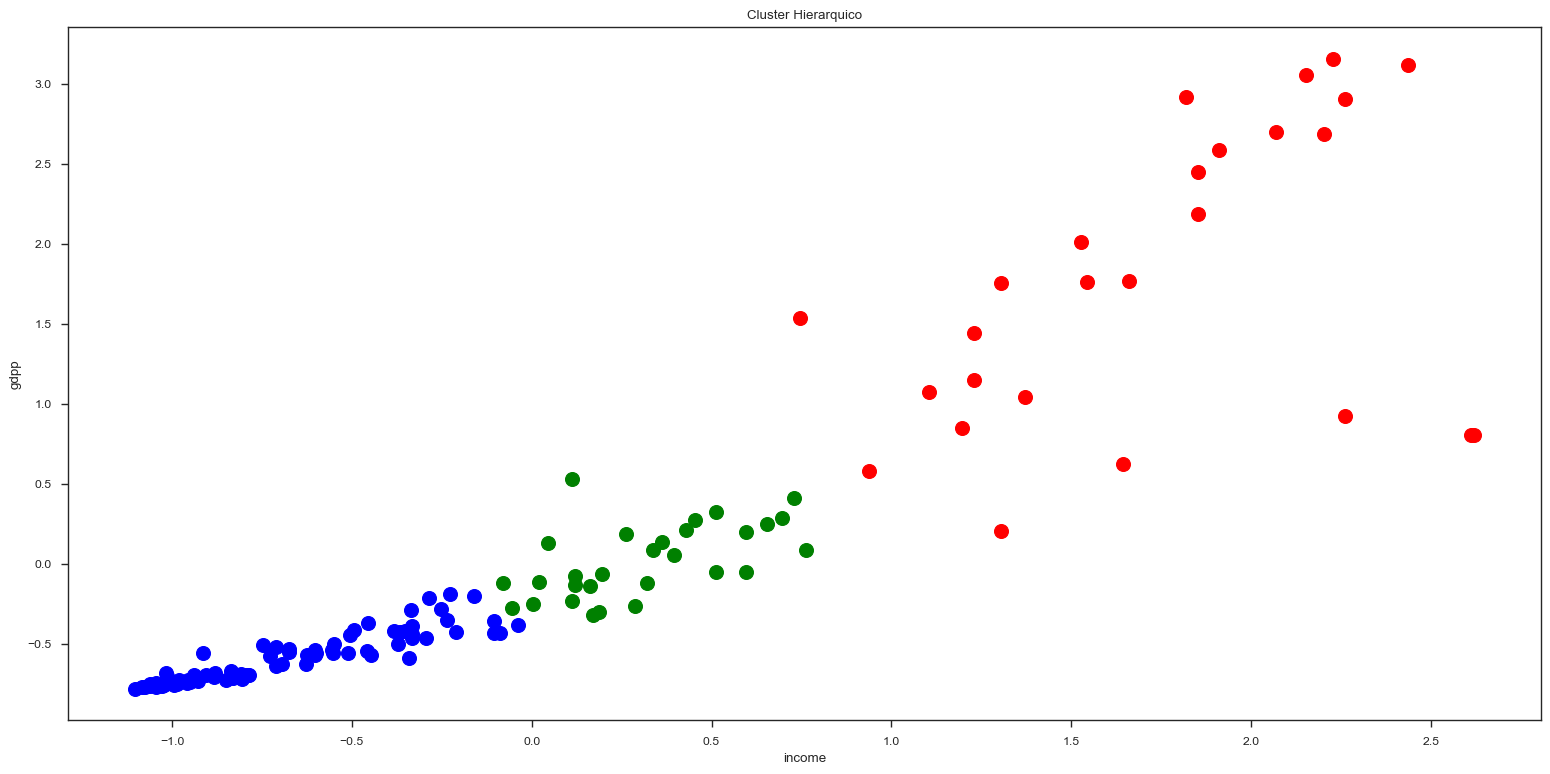

In [140]:
fig = plt.subplots(figsize=(19, 9))
plt.scatter(x_0['income'], x_0['gdpp'],s=100,c="red",label="Cluster1")
plt.scatter(x_1['income'], x_1['gdpp'],s=100,c="blue",label="Cluster2")
plt.scatter(x_2['income'], x_2['gdpp'],s=100,c="green",label="Cluster3")
plt.title("Cluster Hierarquico")
plt.xlabel("income")
plt.ylabel("gdpp")
plt.show()

## Dendrogram

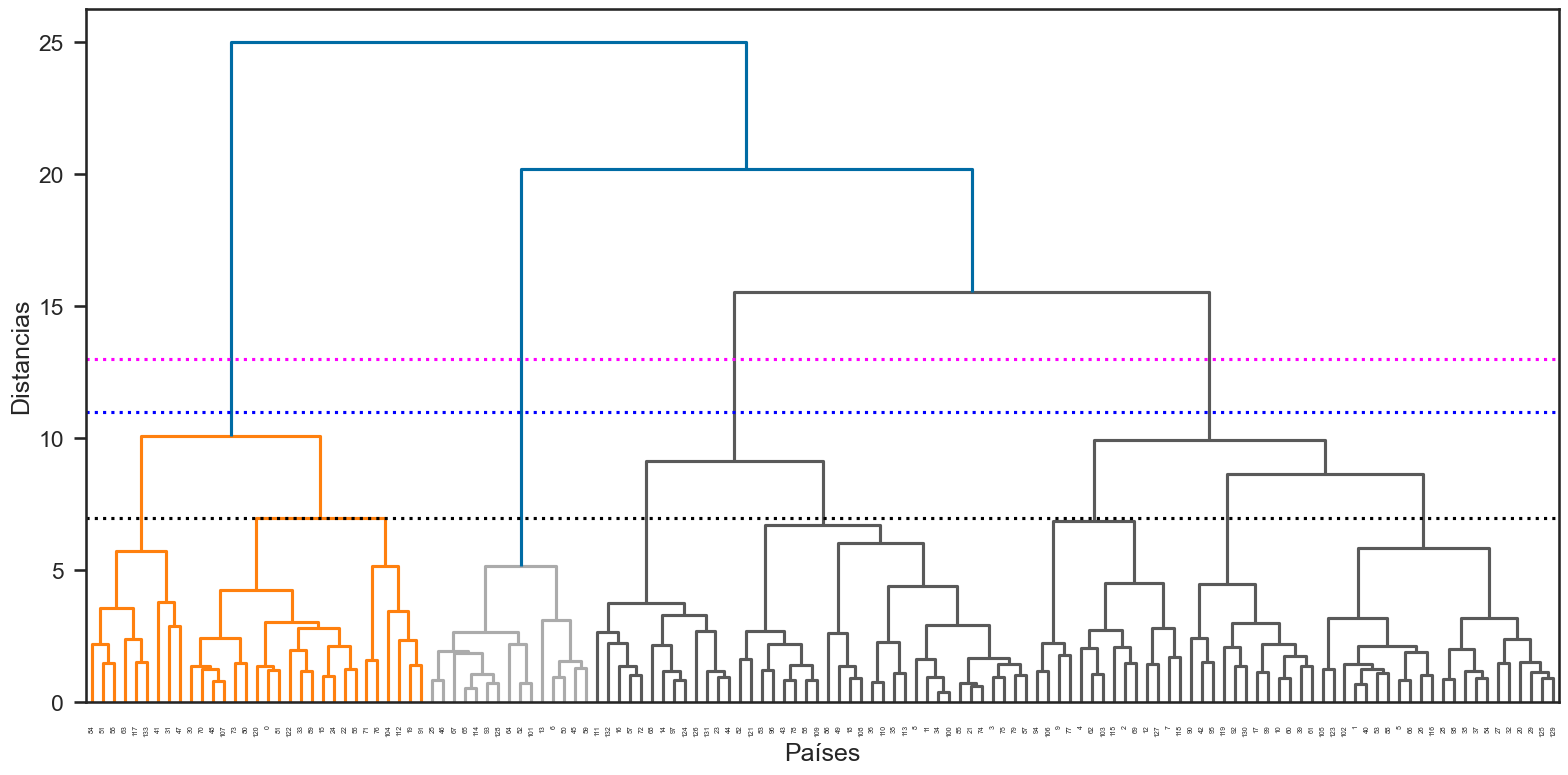

In [141]:
distance_threshold = 13
distance_threshold1 = 7
distance_threshold2 = 11


plt.style.use('tableau-colorblind10')
sns.set_style('ticks')
sns.set_context('talk')
fig, ax = plt.subplots(1, 1, figsize=(19, 9))

linkage = sch.linkage(scaled_data, method="ward")
dendrogram = sch.dendrogram(linkage, labels=scaled_data.index, leaf_rotation=90)

ax.set_xlabel('Países')
ax.set_ylabel('Distancias')
ax.axhline(distance_threshold, color='magenta', ls=":")
ax.axhline(distance_threshold1, color='black', ls=":")
ax.axhline(distance_threshold2, color='blue', ls=":")

The dendrogram visualization of hierarchical clustering provides valuable insights into the structure of the clusters and their relationships. We can observe a clear division occurring in two distinct stages. In the first stage, we identify a cluster represented by the color black (at a distance of 7), where the similarity threshold is slightly below 13. This particular cluster encompasses countries with the poorest socio-economic indicators, showing high levels of poverty. On the other hand, countries with moderate to good indicators share certain common characteristics. At a similarity threshold of around 11 (depicted by the color blue), we notice the presence of two highly similar clusters, differing only in a secondary level of branching in the hierarchical tree.

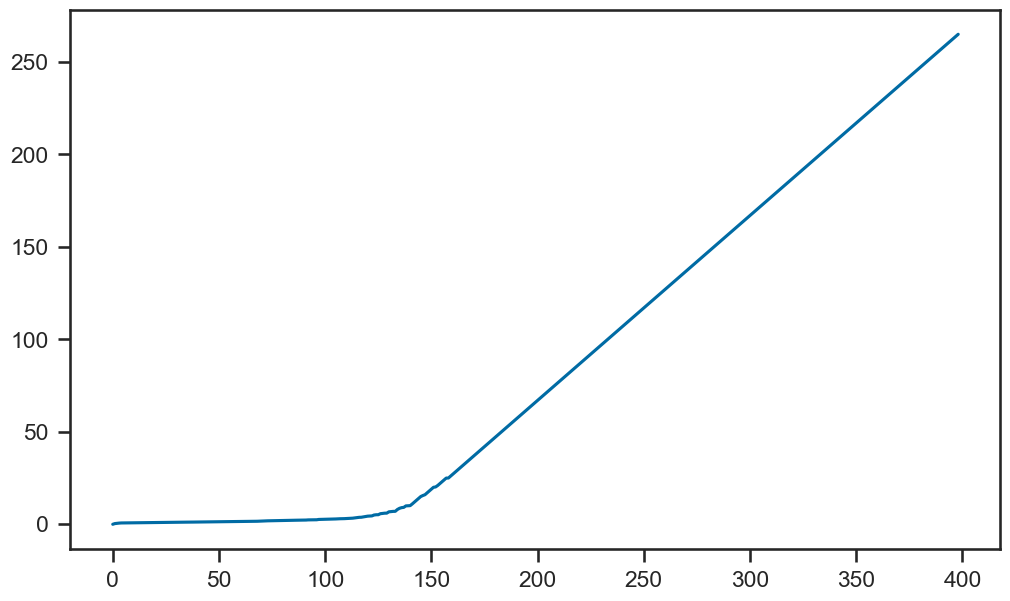

In [142]:
fig = plt.subplots(figsize=(12, 7))
plt.plot(np.unique(linkage))

## Results Comparison

After employing PCA to reduce dimensionality, K-means becomes more effective in segregating variables. Visualizing the PCA components enhances comprehension and provides valuable information about the classification. However, Hierarchical Clustering is more restrictive, as it generates branches that may lead to different clusters, even with identical distances. Hierarchical Clustering offers insights into the data's structure and relationships, enabling more efficient clustering with K-means. In summary, the hierarchical approach serves as a stepping stone to comprehend the data, while K-means is utilized for effective classification.

## Choosing Algorithm 

1. Initialization: Choose K random data points as initial cluster centroids.

Imagine you have a bunch of data points representing different objects or observations. K-means starts by randomly selecting K points from the data and considering them as the initial centers of K clusters.

2. Assignment: Calculate the distance between each data point and the centroids. Assign each data point to the cluster whose centroid is the closest.

For each data point, the algorithm measures the distance to each of the K centroids and assigns the data point to the cluster associated with the closest centroid. This step groups the data points into K clusters based on their proximity to the centroids.

3. Update: Recalculate the centroids of the clusters, considering the average position of the data points assigned to each cluster.

After the initial assignment, the algorithm recalculates the new centroids for each cluster. The new centroid of a cluster is the average position of all the data points that were assigned to that cluster in the previous step.

4. Convergence check: Check if there have been any changes in the assignment of data points to clusters. If there are no changes, the algorithm has converged, and we can stop. Otherwise, go back to the assignment step.

The algorithm repeats steps 2 and 3 until no data points change their cluster assignments in the assignment step. When this happens, the algorithm has reached convergence, meaning the clusters are stable, and we have found our final solution.

5. Repeat steps 2 to 4 until convergence is achieved.

The algorithm keeps repeating steps 2 to 4 until the data points stabilize in their clusters and no longer change their assignments. This ensures that the clusters are well-defined and representative.
The convergence criterion is usually based on a stopping condition, like a maximum number of iterations or when the changes in data point assignments become small enough.

It's important to note that the initial choice of centroids can affect the final results, and different strategies can be used, such as random initialization or more advanced techniques like K-means++.

By following these steps, the K-means algorithm separates the data points into K clusters, with each cluster represented by its centroid. This allows us to analyze and group the data based on their similarities.

## Redoing question #1

In [144]:
centroids = model.cluster_centers_

In [146]:
def distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

In [150]:
def find_medoid(cluster, centroid):
    min_distance = float('inf')
    medoid = None
    for point in cluster:
        dist = distance(point, centroid)
        if dist < min_distance:
            min_distance = dist
            medoid = point
    return medoid

In [155]:
random_indices = np.random.choice(range(len(data_pca)), 3, replace=False)

# Use the random indices to select the random centroids
centroids = data_pca.iloc[random_indices]

# Now 'centroids' contains 3 randomly selected rows (centroids) from the 'data_pca' DataFrame
print(centroids)

        COMP1     COMP2     COMP3     COMP4  cluster
15  -3.306090  0.360290  1.134105  0.688962        1
104 -1.729640  1.270105  2.269450  0.200145        1
5   -0.213095  0.355704 -0.482970 -1.596247        0


In [157]:
data_pca['COMP1'] = pd.to_numeric(data_pca['COMP1'])
data_pca['COMP2'] = pd.to_numeric(data_pca['COMP2'])
data_pca['COMP3'] = pd.to_numeric(data_pca['COMP3'])
data_pca['COMP4'] = pd.to_numeric(data_pca['COMP4'])

# Now the 'data_pca' DataFrame contains all numeric values in the columns 'COMP1', 'COMP2', 'COMP3', and 'COMP4'

# Continue with the K-means algorithm code after preprocessing the data
for _ in range(10000):
    clusters = [[] for _ in range(3)]
    for point in data_pca.values:  # Use .values to convert DataFrame to a 2D numpy array
        distances = euclidean_distances([point], centroids)
        cluster_id = np.argmin(distances)
        clusters[cluster_id].append(point)

    new_centroids = []
    for cluster in clusters:
        centroid = np.mean(cluster, axis=0)
        medoid = find_medoid(cluster, centroid)
        new_centroids.append(medoid)

    if np.array_equal(centroids, new_centroids):
        break

    centroids = new_centroids

In [158]:
model = KMeans(n_clusters=3, init=centroids, n_init=1, max_iter=10000, random_state=42)

In [159]:
model.fit(data_pca)
clusters_mediode = model.labels_

In [160]:
clusters_pca = model.predict(data_pca)
new_data['cluster_mediode'] = clusters_mediode

In [161]:
new_data

country  child_mort  exports  health  imports  income  \
0            Afghanistan        90.2     10.0    7.58     44.9    1610   
1                Albania        16.6     28.0    6.55     48.6    9930   
2                Algeria        27.3     38.4    4.17     31.4   12900   
3    Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   
4              Argentina        14.5     18.9    8.10     16.0   18700   
..                   ...         ...      ...     ...      ...     ...   
129              Uruguay        10.6     26.3    8.35     25.4   17100   
130           Uzbekistan        36.3     31.7    5.81     28.5    4240   
131              Vanuatu        29.2     46.6    5.25     52.7    2950   
132              Vietnam        23.3     72.0    6.84     80.2    4490   
133                Yemen        56.3     30.0    5.18     34.4    4480   

     inflation  life_expec  total_fer   gdpp  Cluster  cluster_pca  \
0         9.44        56.2       5.82    553        1            1   
1         4.49        76.3       1.65   4090        2            0   
2        16.10        76.5       2.89   4460        2            0   
3         1.44        76.8       2.13  12200        2            0   
4        20.90        75.8       2.37  10300        2            0   
..         ...         ...        ...    ...      ...          ...   
129       4.91        76.4       2.08  11900        2            0   
130      16.50        68.8       2.34   1380        2            0   
131       2.62        63.0       3.50   2970        2            0   
132      12.10        73.1       1.95   1310        2            0   
133      23.60        67.5       4.67   1310        1            1   

     cluster_mediode  
0                  0  
1                  1  
2                  1  
3                  1  
4                  1  
..               ...  
129                1  
130                1  
131                1  
132                1  
133                0  

[134 rows x 13 columns]

Sensitivity to outliers and Influence of DBSCAN

The K-means algorithm is sensitive to outliers in the data because it is based on minimizing the sum of squared distances between data points and their assigned cluster centroids. Outliers are data points that are significantly different from the rest of the data, and they can have a large impact on the centroid positions and the overall clustering result.

When K-means encounters an outlier, it may assign it to a cluster even if it does not belong there, which can lead to distorted cluster boundaries and inaccurate cluster representation. Additionally, the centroid of a cluster can be significantly influenced by an outlier, pulling the centroid away from the true center of the cluster.

On the other hand, the DBSCAN (Density-Based Spatial Clustering of Applications with Noise) algorithm is more robust to the presence of outliers. DBSCAN defines clusters based on density and does not rely on centroids. It groups data points based on their proximity to each other, and outliers that are isolated in low-density regions are considered noise and are not assigned to any cluster.

In DBSCAN, a data point is considered a core point if it has a minimum number of neighboring data points within a specified distance (defined by two parameters: epsilon and minPoints). Core points form the core of a cluster, and other data points that are close enough to core points are considered part of the same cluster. Data points that are not core points and are not close enough to any core points are classified as outliers.

This density-based approach makes DBSCAN more resilient to outliers because outliers are typically isolated and do not meet the criteria to be core points. As a result, DBSCAN does not force outliers into clusters and can accurately identify and exclude them as noise.

In summary, the K-means algorithm is sensitive to outliers as they can distort the cluster formation and centroid positions. On the other hand, DBSCAN is more robust to outliers due to its density-based approach, which allows it to identify and exclude outliers as noise and form more accurate clusters based on data density.